In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'scale',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_scale_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 828)
(734160, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:27 - loss: 0.0632 - STD: 1.9699e-04 - MAE: 0.2346

 4/74 [>.............................] - ETA: 1s - loss: 0.0270 - STD: 2.7763e-04 - MAE: 0.1288  

 5/74 [=>............................] - ETA: 2s - loss: 0.0264 - STD: 2.5804e-04 - MAE: 0.1280

 6/74 [=>............................] - ETA: 2s - loss: 0.0264 - STD: 2.4008e-04 - MAE: 0.1284

 7/74 [=>............................] - ETA: 2s - loss: 0.0263 - STD: 2.2468e-04 - MAE: 0.1288

 8/74 [==>...........................] - ETA: 2s - loss: 0.0261 - STD: 2.1250e-04 - MAE: 0.1284

 9/74 [==>...........................] - ETA: 3s - loss: 0.0256 - STD: 2.0335e-04 - MAE: 0.1272

10/74 [===>..........................] - ETA: 3s - loss: 0.0251 - STD: 1.9679e-04 - MAE: 0.1255

11/74 [===>..........................] - ETA: 3s - loss: 0.0245 - STD: 1.9251e-04 - MAE: 0.1232

12/74 [===>..........................] - ETA: 3s - loss: 0.0236 - STD: 1.9036e-04 - MAE: 0.1203

13/74 [====>.........................] - ETA: 3s - loss: 0.0227 - STD: 1.8996e-04 - MAE: 0.1170

14/74 [====>.........................] - ETA: 3s - loss: 0.0218 - STD: 1.9082e-04 - MAE: 0.1139

15/74 [=====>........................] - ETA: 3s - loss: 0.0210 - STD: 1.9300e-04 - MAE: 0.1114

16/74 [=====>........................] - ETA: 3s - loss: 0.0203 - STD: 1.9564e-04 - MAE: 0.1096

17/74 [=====>........................] - ETA: 2s - loss: 0.0198 - STD: 1.9882e-04 - MAE: 0.1086

18/74 [======>.......................] - ETA: 2s - loss: 0.0194 - STD: 2.0199e-04 - MAE: 0.1080

19/74 [======>.......................] - ETA: 2s - loss: 0.0190 - STD: 2.0496e-04 - MAE: 0.1075

20/74 [=======>......................] - ETA: 2s - loss: 0.0187 - STD: 2.0786e-04 - MAE: 0.1069

21/74 [=======>......................] - ETA: 2s - loss: 0.0184 - STD: 2.1059e-04 - MAE: 0.1061

22/74 [=======>......................] - ETA: 2s - loss: 0.0180 - STD: 2.1269e-04 - MAE: 0.1050

23/74 [========>.....................] - ETA: 2s - loss: 0.0176 - STD: 2.1452e-04 - MAE: 0.1038

24/74 [========>.....................] - ETA: 2s - loss: 0.0173 - STD: 2.1598e-04 - MAE: 0.1027

25/74 [=========>....................] - ETA: 2s - loss: 0.0170 - STD: 2.1701e-04 - MAE: 0.1015

26/74 [=========>....................] - ETA: 2s - loss: 0.0167 - STD: 2.1792e-04 - MAE: 0.1004

27/74 [=========>....................] - ETA: 2s - loss: 0.0164 - STD: 2.1850e-04 - MAE: 0.0995

28/74 [==========>...................] - ETA: 2s - loss: 0.0162 - STD: 2.1911e-04 - MAE: 0.0986

29/74 [==========>...................] - ETA: 2s - loss: 0.0160 - STD: 2.1979e-04 - MAE: 0.0977

30/74 [===========>..................] - ETA: 2s - loss: 0.0158 - STD: 2.2072e-04 - MAE: 0.0970

31/74 [===========>..................] - ETA: 2s - loss: 0.0157 - STD: 2.2200e-04 - MAE: 0.0963

32/74 [===========>..................] - ETA: 2s - loss: 0.0155 - STD: 2.2360e-04 - MAE: 0.0956

33/74 [============>.................] - ETA: 2s - loss: 0.0154 - STD: 2.2548e-04 - MAE: 0.0949

37/74 [==============>...............] - ETA: 2s - loss: 0.0147 - STD: 2.3732e-04 - MAE: 0.0928

38/74 [==============>...............] - ETA: 2s - loss: 0.0146 - STD: 2.4104e-04 - MAE: 0.0925

39/74 [==============>...............] - ETA: 2s - loss: 0.0145 - STD: 2.4482e-04 - MAE: 0.0922

40/74 [===============>..............] - ETA: 2s - loss: 0.0143 - STD: 2.4868e-04 - MAE: 0.0919

41/74 [===============>..............] - ETA: 2s - loss: 0.0142 - STD: 2.5274e-04 - MAE: 0.0916

42/74 [================>.............] - ETA: 2s - loss: 0.0141 - STD: 2.5674e-04 - MAE: 0.0913

43/74 [================>.............] - ETA: 1s - loss: 0.0140 - STD: 2.6064e-04 - MAE: 0.0910

44/74 [================>.............] - ETA: 1s - loss: 0.0139 - STD: 2.6439e-04 - MAE: 0.0907

45/74 [=================>............] - ETA: 1s - loss: 0.0138 - STD: 2.6816e-04 - MAE: 0.0903

46/74 [=================>............] - ETA: 1s - loss: 0.0137 - STD: 2.7178e-04 - MAE: 0.0900

47/74 [==================>...........] - ETA: 1s - loss: 0.0136 - STD: 2.7550e-04 - MAE: 0.0897

48/74 [==================>...........] - ETA: 1s - loss: 0.0135 - STD: 2.7921e-04 - MAE: 0.0893

49/74 [==================>...........] - ETA: 1s - loss: 0.0134 - STD: 2.8290e-04 - MAE: 0.0890

50/74 [===================>..........] - ETA: 1s - loss: 0.0133 - STD: 2.8692e-04 - MAE: 0.0887

51/74 [===================>..........] - ETA: 1s - loss: 0.0133 - STD: 2.9093e-04 - MAE: 0.0884

52/74 [====================>.........] - ETA: 1s - loss: 0.0132 - STD: 2.9503e-04 - MAE: 0.0882

53/74 [====================>.........] - ETA: 1s - loss: 0.0131 - STD: 2.9960e-04 - MAE: 0.0879

54/74 [====================>.........] - ETA: 1s - loss: 0.0130 - STD: 3.0449e-04 - MAE: 0.0877

55/74 [=====================>........] - ETA: 1s - loss: 0.0130 - STD: 3.0945e-04 - MAE: 0.0874

56/74 [=====================>........] - ETA: 1s - loss: 0.0129 - STD: 3.1465e-04 - MAE: 0.0872

57/74 [======================>.......] - ETA: 1s - loss: 0.0128 - STD: 3.2014e-04 - MAE: 0.0870

58/74 [======================>.......] - ETA: 0s - loss: 0.0128 - STD: 3.2571e-04 - MAE: 0.0868

59/74 [======================>.......] - ETA: 0s - loss: 0.0127 - STD: 3.3148e-04 - MAE: 0.0867

60/74 [=======================>......] - ETA: 0s - loss: 0.0126 - STD: 3.3746e-04 - MAE: 0.0865

61/74 [=======================>......] - ETA: 0s - loss: 0.0126 - STD: 3.4370e-04 - MAE: 0.0863

62/74 [========================>.....] - ETA: 0s - loss: 0.0125 - STD: 3.5005e-04 - MAE: 0.0862

63/74 [========================>.....] - ETA: 0s - loss: 0.0125 - STD: 3.5642e-04 - MAE: 0.0860

64/74 [========================>.....] - ETA: 0s - loss: 0.0124 - STD: 3.6301e-04 - MAE: 0.0858

65/74 [=========================>....] - ETA: 0s - loss: 0.0124 - STD: 3.6930e-04 - MAE: 0.0856

66/74 [=========================>....] - ETA: 0s - loss: 0.0123 - STD: 3.7579e-04 - MAE: 0.0855

67/74 [==========================>...] - ETA: 0s - loss: 0.0123 - STD: 3.8258e-04 - MAE: 0.0853

68/74 [==========================>...] - ETA: 0s - loss: 0.0122 - STD: 3.8951e-04 - MAE: 0.0852

69/74 [==========================>...] - ETA: 0s - loss: 0.0122 - STD: 3.9667e-04 - MAE: 0.0850

70/74 [===========================>..] - ETA: 0s - loss: 0.0121 - STD: 4.0414e-04 - MAE: 0.0849

71/74 [===========================>..] - ETA: 0s - loss: 0.0121 - STD: 4.1167e-04 - MAE: 0.0847

72/74 [============================>.] - ETA: 0s - loss: 0.0121 - STD: 4.1976e-04 - MAE: 0.0846

73/74 [============================>.] - ETA: 0s - loss: 0.0120 - STD: 4.2816e-04 - MAE: 0.0844

74/74 [==============================] - ETA: 0s - loss: 0.0120 - STD: 4.3695e-04 - MAE: 0.0843

74/74 [==============================] - 6s 69ms/step - loss: 0.0120 - STD: 4.3695e-04 - MAE: 0.0843 - val_loss: 0.0085 - val_STD: 7.2233e-04 - val_MAE: 0.0715


Epoch 2/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0091 - STD: 0.0011 - MAE: 0.0753

 2/74 [..............................] - ETA: 4s - loss: 0.0091 - STD: 0.0011 - MAE: 0.0756

 3/74 [>.............................] - ETA: 4s - loss: 0.0092 - STD: 0.0012 - MAE: 0.0757

 4/74 [>.............................] - ETA: 4s - loss: 0.0091 - STD: 0.0012 - MAE: 0.0756

 5/74 [=>............................] - ETA: 4s - loss: 0.0091 - STD: 0.0012 - MAE: 0.0756

 6/74 [=>............................] - ETA: 4s - loss: 0.0091 - STD: 0.0012 - MAE: 0.0753

 7/74 [=>............................] - ETA: 4s - loss: 0.0091 - STD: 0.0012 - MAE: 0.0752

 8/74 [==>...........................] - ETA: 4s - loss: 0.0090 - STD: 0.0013 - MAE: 0.0751

 9/74 [==>...........................] - ETA: 3s - loss: 0.0090 - STD: 0.0013 - MAE: 0.0750

10/74 [===>..........................] - ETA: 3s - loss: 0.0090 - STD: 0.0013 - MAE: 0.0750

11/74 [===>..........................] - ETA: 3s - loss: 0.0090 - STD: 0.0013 - MAE: 0.0749

12/74 [===>..........................] - ETA: 3s - loss: 0.0091 - STD: 0.0014 - MAE: 0.0750

13/74 [====>.........................] - ETA: 3s - loss: 0.0091 - STD: 0.0014 - MAE: 0.0750

14/74 [====>.........................] - ETA: 3s - loss: 0.0091 - STD: 0.0014 - MAE: 0.0751

15/74 [=====>........................] - ETA: 3s - loss: 0.0091 - STD: 0.0015 - MAE: 0.0750

16/74 [=====>........................] - ETA: 3s - loss: 0.0091 - STD: 0.0015 - MAE: 0.0751

17/74 [=====>........................] - ETA: 3s - loss: 0.0091 - STD: 0.0015 - MAE: 0.0751

18/74 [======>.......................] - ETA: 3s - loss: 0.0091 - STD: 0.0016 - MAE: 0.0751

19/74 [======>.......................] - ETA: 3s - loss: 0.0091 - STD: 0.0016 - MAE: 0.0751

20/74 [=======>......................] - ETA: 3s - loss: 0.0091 - STD: 0.0016 - MAE: 0.0751

21/74 [=======>......................] - ETA: 3s - loss: 0.0091 - STD: 0.0017 - MAE: 0.0751

22/74 [=======>......................] - ETA: 3s - loss: 0.0091 - STD: 0.0017 - MAE: 0.0751

23/74 [========>.....................] - ETA: 3s - loss: 0.0091 - STD: 0.0018 - MAE: 0.0750

24/74 [========>.....................] - ETA: 2s - loss: 0.0091 - STD: 0.0018 - MAE: 0.0750

25/74 [=========>....................] - ETA: 2s - loss: 0.0091 - STD: 0.0018 - MAE: 0.0750

26/74 [=========>....................] - ETA: 2s - loss: 0.0091 - STD: 0.0019 - MAE: 0.0750

27/74 [=========>....................] - ETA: 2s - loss: 0.0091 - STD: 0.0019 - MAE: 0.0749

28/74 [==========>...................] - ETA: 2s - loss: 0.0091 - STD: 0.0020 - MAE: 0.0749

29/74 [==========>...................] - ETA: 2s - loss: 0.0091 - STD: 0.0021 - MAE: 0.0749

30/74 [===========>..................] - ETA: 2s - loss: 0.0090 - STD: 0.0021 - MAE: 0.0748

31/74 [===========>..................] - ETA: 2s - loss: 0.0090 - STD: 0.0022 - MAE: 0.0748

32/74 [===========>..................] - ETA: 2s - loss: 0.0090 - STD: 0.0022 - MAE: 0.0748

33/74 [============>.................] - ETA: 2s - loss: 0.0090 - STD: 0.0023 - MAE: 0.0748

35/74 [=============>................] - ETA: 2s - loss: 0.0090 - STD: 0.0024 - MAE: 0.0748

36/74 [=============>................] - ETA: 2s - loss: 0.0090 - STD: 0.0025 - MAE: 0.0747

37/74 [==============>...............] - ETA: 2s - loss: 0.0090 - STD: 0.0026 - MAE: 0.0747

38/74 [==============>...............] - ETA: 2s - loss: 0.0090 - STD: 0.0027 - MAE: 0.0747

39/74 [==============>...............] - ETA: 2s - loss: 0.0090 - STD: 0.0028 - MAE: 0.0746

40/74 [===============>..............] - ETA: 1s - loss: 0.0090 - STD: 0.0029 - MAE: 0.0746

41/74 [===============>..............] - ETA: 1s - loss: 0.0090 - STD: 0.0030 - MAE: 0.0746

42/74 [================>.............] - ETA: 1s - loss: 0.0090 - STD: 0.0031 - MAE: 0.0746

43/74 [================>.............] - ETA: 1s - loss: 0.0090 - STD: 0.0032 - MAE: 0.0746

44/74 [================>.............] - ETA: 1s - loss: 0.0090 - STD: 0.0033 - MAE: 0.0745

45/74 [=================>............] - ETA: 1s - loss: 0.0089 - STD: 0.0034 - MAE: 0.0745

46/74 [=================>............] - ETA: 1s - loss: 0.0089 - STD: 0.0035 - MAE: 0.0745

47/74 [==================>...........] - ETA: 1s - loss: 0.0089 - STD: 0.0037 - MAE: 0.0744

48/74 [==================>...........] - ETA: 1s - loss: 0.0089 - STD: 0.0038 - MAE: 0.0744

49/74 [==================>...........] - ETA: 1s - loss: 0.0089 - STD: 0.0039 - MAE: 0.0743

50/74 [===================>..........] - ETA: 1s - loss: 0.0089 - STD: 0.0041 - MAE: 0.0743

51/74 [===================>..........] - ETA: 1s - loss: 0.0089 - STD: 0.0042 - MAE: 0.0742

52/74 [====================>.........] - ETA: 1s - loss: 0.0089 - STD: 0.0044 - MAE: 0.0742

53/74 [====================>.........] - ETA: 1s - loss: 0.0089 - STD: 0.0046 - MAE: 0.0742

54/74 [====================>.........] - ETA: 1s - loss: 0.0088 - STD: 0.0048 - MAE: 0.0741

55/74 [=====================>........] - ETA: 1s - loss: 0.0088 - STD: 0.0050 - MAE: 0.0741

56/74 [=====================>........] - ETA: 1s - loss: 0.0088 - STD: 0.0052 - MAE: 0.0740

57/74 [======================>.......] - ETA: 0s - loss: 0.0088 - STD: 0.0054 - MAE: 0.0740

58/74 [======================>.......] - ETA: 0s - loss: 0.0088 - STD: 0.0056 - MAE: 0.0739

59/74 [======================>.......] - ETA: 0s - loss: 0.0088 - STD: 0.0058 - MAE: 0.0739

60/74 [=======================>......] - ETA: 0s - loss: 0.0088 - STD: 0.0061 - MAE: 0.0738

61/74 [=======================>......] - ETA: 0s - loss: 0.0087 - STD: 0.0063 - MAE: 0.0738

62/74 [========================>.....] - ETA: 0s - loss: 0.0087 - STD: 0.0066 - MAE: 0.0737

63/74 [========================>.....] - ETA: 0s - loss: 0.0087 - STD: 0.0068 - MAE: 0.0736

64/74 [========================>.....] - ETA: 0s - loss: 0.0087 - STD: 0.0071 - MAE: 0.0736

65/74 [=========================>....] - ETA: 0s - loss: 0.0087 - STD: 0.0074 - MAE: 0.0735

66/74 [=========================>....] - ETA: 0s - loss: 0.0086 - STD: 0.0077 - MAE: 0.0734

67/74 [==========================>...] - ETA: 0s - loss: 0.0086 - STD: 0.0080 - MAE: 0.0733

68/74 [==========================>...] - ETA: 0s - loss: 0.0086 - STD: 0.0083 - MAE: 0.0733

69/74 [==========================>...] - ETA: 0s - loss: 0.0086 - STD: 0.0086 - MAE: 0.0732

70/74 [===========================>..] - ETA: 0s - loss: 0.0086 - STD: 0.0089 - MAE: 0.0732

71/74 [===========================>..] - ETA: 0s - loss: 0.0086 - STD: 0.0093 - MAE: 0.0731

72/74 [============================>.] - ETA: 0s - loss: 0.0086 - STD: 0.0096 - MAE: 0.0730

73/74 [============================>.] - ETA: 0s - loss: 0.0085 - STD: 0.0099 - MAE: 0.0729

74/74 [==============================] - ETA: 0s - loss: 0.0085 - STD: 0.0103 - MAE: 0.0729

74/74 [==============================] - 5s 61ms/step - loss: 0.0085 - STD: 0.0103 - MAE: 0.0729 - val_loss: 0.0067 - val_STD: 0.0228 - val_MAE: 0.0630


Epoch 3/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0072 - STD: 0.0357 - MAE: 0.0670

 2/74 [..............................] - ETA: 4s - loss: 0.0073 - STD: 0.0361 - MAE: 0.0671

 3/74 [>.............................] - ETA: 4s - loss: 0.0072 - STD: 0.0365 - MAE: 0.0670

 4/74 [>.............................] - ETA: 4s - loss: 0.0072 - STD: 0.0369 - MAE: 0.0670

 5/74 [=>............................] - ETA: 4s - loss: 0.0072 - STD: 0.0373 - MAE: 0.0670

 6/74 [=>............................] - ETA: 4s - loss: 0.0072 - STD: 0.0376 - MAE: 0.0670

 7/74 [=>............................] - ETA: 3s - loss: 0.0072 - STD: 0.0379 - MAE: 0.0670

 8/74 [==>...........................] - ETA: 3s - loss: 0.0072 - STD: 0.0381 - MAE: 0.0669

 9/74 [==>...........................] - ETA: 3s - loss: 0.0072 - STD: 0.0384 - MAE: 0.0669

10/74 [===>..........................] - ETA: 3s - loss: 0.0072 - STD: 0.0385 - MAE: 0.0668

11/74 [===>..........................] - ETA: 3s - loss: 0.0072 - STD: 0.0387 - MAE: 0.0668

12/74 [===>..........................] - ETA: 3s - loss: 0.0072 - STD: 0.0390 - MAE: 0.0668

13/74 [====>.........................] - ETA: 3s - loss: 0.0072 - STD: 0.0391 - MAE: 0.0668

14/74 [====>.........................] - ETA: 3s - loss: 0.0072 - STD: 0.0393 - MAE: 0.0666

15/74 [=====>........................] - ETA: 3s - loss: 0.0072 - STD: 0.0394 - MAE: 0.0666

16/74 [=====>........................] - ETA: 3s - loss: 0.0072 - STD: 0.0396 - MAE: 0.0665

17/74 [=====>........................] - ETA: 3s - loss: 0.0071 - STD: 0.0397 - MAE: 0.0664

18/74 [======>.......................] - ETA: 3s - loss: 0.0071 - STD: 0.0398 - MAE: 0.0665

19/74 [======>.......................] - ETA: 3s - loss: 0.0071 - STD: 0.0399 - MAE: 0.0664

20/74 [=======>......................] - ETA: 3s - loss: 0.0071 - STD: 0.0400 - MAE: 0.0664

21/74 [=======>......................] - ETA: 3s - loss: 0.0071 - STD: 0.0401 - MAE: 0.0663

22/74 [=======>......................] - ETA: 3s - loss: 0.0071 - STD: 0.0402 - MAE: 0.0663

23/74 [========>.....................] - ETA: 3s - loss: 0.0071 - STD: 0.0403 - MAE: 0.0663

24/74 [========>.....................] - ETA: 3s - loss: 0.0071 - STD: 0.0404 - MAE: 0.0663

25/74 [=========>....................] - ETA: 2s - loss: 0.0071 - STD: 0.0405 - MAE: 0.0662

26/74 [=========>....................] - ETA: 2s - loss: 0.0071 - STD: 0.0406 - MAE: 0.0662

27/74 [=========>....................] - ETA: 2s - loss: 0.0071 - STD: 0.0407 - MAE: 0.0662

29/74 [==========>...................] - ETA: 2s - loss: 0.0071 - STD: 0.0409 - MAE: 0.0661

30/74 [===========>..................] - ETA: 2s - loss: 0.0071 - STD: 0.0409 - MAE: 0.0661

31/74 [===========>..................] - ETA: 2s - loss: 0.0071 - STD: 0.0410 - MAE: 0.0661

32/74 [===========>..................] - ETA: 2s - loss: 0.0071 - STD: 0.0411 - MAE: 0.0661

33/74 [============>.................] - ETA: 2s - loss: 0.0071 - STD: 0.0412 - MAE: 0.0660

34/74 [============>.................] - ETA: 2s - loss: 0.0071 - STD: 0.0413 - MAE: 0.0660

35/74 [=============>................] - ETA: 2s - loss: 0.0071 - STD: 0.0414 - MAE: 0.0659

36/74 [=============>................] - ETA: 2s - loss: 0.0071 - STD: 0.0415 - MAE: 0.0659

37/74 [==============>...............] - ETA: 2s - loss: 0.0071 - STD: 0.0415 - MAE: 0.0659

38/74 [==============>...............] - ETA: 2s - loss: 0.0071 - STD: 0.0416 - MAE: 0.0659

39/74 [==============>...............] - ETA: 2s - loss: 0.0071 - STD: 0.0417 - MAE: 0.0658

40/74 [===============>..............] - ETA: 2s - loss: 0.0070 - STD: 0.0418 - MAE: 0.0658

41/74 [===============>..............] - ETA: 1s - loss: 0.0070 - STD: 0.0418 - MAE: 0.0658

42/74 [================>.............] - ETA: 1s - loss: 0.0070 - STD: 0.0419 - MAE: 0.0658

43/74 [================>.............] - ETA: 1s - loss: 0.0070 - STD: 0.0420 - MAE: 0.0657

44/74 [================>.............] - ETA: 1s - loss: 0.0070 - STD: 0.0420 - MAE: 0.0657

45/74 [=================>............] - ETA: 1s - loss: 0.0070 - STD: 0.0421 - MAE: 0.0656

46/74 [=================>............] - ETA: 1s - loss: 0.0070 - STD: 0.0422 - MAE: 0.0656

47/74 [==================>...........] - ETA: 1s - loss: 0.0070 - STD: 0.0422 - MAE: 0.0656

48/74 [==================>...........] - ETA: 1s - loss: 0.0070 - STD: 0.0423 - MAE: 0.0655

49/74 [==================>...........] - ETA: 1s - loss: 0.0070 - STD: 0.0423 - MAE: 0.0655

50/74 [===================>..........] - ETA: 1s - loss: 0.0070 - STD: 0.0424 - MAE: 0.0655

51/74 [===================>..........] - ETA: 1s - loss: 0.0070 - STD: 0.0424 - MAE: 0.0654

52/74 [====================>.........] - ETA: 1s - loss: 0.0070 - STD: 0.0425 - MAE: 0.0654

53/74 [====================>.........] - ETA: 1s - loss: 0.0070 - STD: 0.0425 - MAE: 0.0654

54/74 [====================>.........] - ETA: 1s - loss: 0.0070 - STD: 0.0426 - MAE: 0.0653

55/74 [=====================>........] - ETA: 1s - loss: 0.0070 - STD: 0.0427 - MAE: 0.0653

56/74 [=====================>........] - ETA: 1s - loss: 0.0070 - STD: 0.0427 - MAE: 0.0653

57/74 [======================>.......] - ETA: 1s - loss: 0.0070 - STD: 0.0428 - MAE: 0.0652

58/74 [======================>.......] - ETA: 0s - loss: 0.0069 - STD: 0.0428 - MAE: 0.0652

59/74 [======================>.......] - ETA: 0s - loss: 0.0069 - STD: 0.0429 - MAE: 0.0651

60/74 [=======================>......] - ETA: 0s - loss: 0.0069 - STD: 0.0429 - MAE: 0.0651

61/74 [=======================>......] - ETA: 0s - loss: 0.0069 - STD: 0.0430 - MAE: 0.0650

62/74 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.0431 - MAE: 0.0650

63/74 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.0431 - MAE: 0.0650

64/74 [========================>.....] - ETA: 0s - loss: 0.0069 - STD: 0.0432 - MAE: 0.0649

65/74 [=========================>....] - ETA: 0s - loss: 0.0069 - STD: 0.0432 - MAE: 0.0649

66/74 [=========================>....] - ETA: 0s - loss: 0.0069 - STD: 0.0433 - MAE: 0.0648

67/74 [==========================>...] - ETA: 0s - loss: 0.0069 - STD: 0.0433 - MAE: 0.0648

68/74 [==========================>...] - ETA: 0s - loss: 0.0069 - STD: 0.0434 - MAE: 0.0647

69/74 [==========================>...] - ETA: 0s - loss: 0.0069 - STD: 0.0434 - MAE: 0.0647

70/74 [===========================>..] - ETA: 0s - loss: 0.0069 - STD: 0.0434 - MAE: 0.0646

71/74 [===========================>..] - ETA: 0s - loss: 0.0069 - STD: 0.0435 - MAE: 0.0646

72/74 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0436 - MAE: 0.0646

73/74 [============================>.] - ETA: 0s - loss: 0.0068 - STD: 0.0436 - MAE: 0.0645

74/74 [==============================] - ETA: 0s - loss: 0.0068 - STD: 0.0437 - MAE: 0.0644

74/74 [==============================] - 5s 63ms/step - loss: 0.0068 - STD: 0.0437 - MAE: 0.0644 - val_loss: 0.0057 - val_STD: 0.0314 - val_MAE: 0.0558


Epoch 4/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0059 - STD: 0.0478 - MAE: 0.0591

 2/74 [..............................] - ETA: 4s - loss: 0.0059 - STD: 0.0486 - MAE: 0.0593

 3/74 [>.............................] - ETA: 4s - loss: 0.0059 - STD: 0.0491 - MAE: 0.0595

 4/74 [>.............................] - ETA: 4s - loss: 0.0059 - STD: 0.0491 - MAE: 0.0594

 5/74 [=>............................] - ETA: 4s - loss: 0.0059 - STD: 0.0491 - MAE: 0.0594

 6/74 [=>............................] - ETA: 4s - loss: 0.0059 - STD: 0.0494 - MAE: 0.0594

 7/74 [=>............................] - ETA: 4s - loss: 0.0059 - STD: 0.0496 - MAE: 0.0594

 8/74 [==>...........................] - ETA: 3s - loss: 0.0059 - STD: 0.0496 - MAE: 0.0592

 9/74 [==>...........................] - ETA: 3s - loss: 0.0059 - STD: 0.0498 - MAE: 0.0592

10/74 [===>..........................] - ETA: 3s - loss: 0.0058 - STD: 0.0500 - MAE: 0.0591

11/74 [===>..........................] - ETA: 3s - loss: 0.0058 - STD: 0.0502 - MAE: 0.0589

12/74 [===>..........................] - ETA: 3s - loss: 0.0058 - STD: 0.0504 - MAE: 0.0588

13/74 [====>.........................] - ETA: 3s - loss: 0.0058 - STD: 0.0508 - MAE: 0.0587

14/74 [====>.........................] - ETA: 3s - loss: 0.0058 - STD: 0.0510 - MAE: 0.0586

15/74 [=====>........................] - ETA: 3s - loss: 0.0057 - STD: 0.0514 - MAE: 0.0584

16/74 [=====>........................] - ETA: 3s - loss: 0.0057 - STD: 0.0517 - MAE: 0.0583

17/74 [=====>........................] - ETA: 3s - loss: 0.0057 - STD: 0.0520 - MAE: 0.0582

18/74 [======>.......................] - ETA: 3s - loss: 0.0057 - STD: 0.0524 - MAE: 0.0582

19/74 [======>.......................] - ETA: 3s - loss: 0.0057 - STD: 0.0526 - MAE: 0.0581

20/74 [=======>......................] - ETA: 3s - loss: 0.0057 - STD: 0.0531 - MAE: 0.0581

21/74 [=======>......................] - ETA: 3s - loss: 0.0057 - STD: 0.0533 - MAE: 0.0579

22/74 [=======>......................] - ETA: 3s - loss: 0.0056 - STD: 0.0535 - MAE: 0.0578

23/74 [========>.....................] - ETA: 3s - loss: 0.0056 - STD: 0.0538 - MAE: 0.0577

24/74 [========>.....................] - ETA: 3s - loss: 0.0056 - STD: 0.0540 - MAE: 0.0576

25/74 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.0542 - MAE: 0.0575

26/74 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.0545 - MAE: 0.0575

27/74 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.0547 - MAE: 0.0574

28/74 [==========>...................] - ETA: 2s - loss: 0.0055 - STD: 0.0548 - MAE: 0.0572

29/74 [==========>...................] - ETA: 2s - loss: 0.0055 - STD: 0.0551 - MAE: 0.0572

30/74 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.0551 - MAE: 0.0571

31/74 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.0554 - MAE: 0.0571

32/74 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.0556 - MAE: 0.0570

33/74 [============>.................] - ETA: 2s - loss: 0.0055 - STD: 0.0556 - MAE: 0.0569

34/74 [============>.................] - ETA: 2s - loss: 0.0055 - STD: 0.0559 - MAE: 0.0570

36/74 [=============>................] - ETA: 2s - loss: 0.0055 - STD: 0.0560 - MAE: 0.0568

37/74 [==============>...............] - ETA: 2s - loss: 0.0055 - STD: 0.0563 - MAE: 0.0568

38/74 [==============>...............] - ETA: 2s - loss: 0.0055 - STD: 0.0563 - MAE: 0.0567

39/74 [==============>...............] - ETA: 2s - loss: 0.0055 - STD: 0.0564 - MAE: 0.0566

40/74 [===============>..............] - ETA: 2s - loss: 0.0055 - STD: 0.0566 - MAE: 0.0567

41/74 [===============>..............] - ETA: 1s - loss: 0.0054 - STD: 0.0566 - MAE: 0.0566

42/74 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0567 - MAE: 0.0565

43/74 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0569 - MAE: 0.0565

44/74 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0569 - MAE: 0.0564

45/74 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0570 - MAE: 0.0564

46/74 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0572 - MAE: 0.0563

47/74 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0572 - MAE: 0.0563

48/74 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0573 - MAE: 0.0562

49/74 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0575 - MAE: 0.0562

50/74 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0575 - MAE: 0.0561

51/74 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0576 - MAE: 0.0560

52/74 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0577 - MAE: 0.0560

53/74 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0578 - MAE: 0.0559

54/74 [====================>.........] - ETA: 1s - loss: 0.0053 - STD: 0.0579 - MAE: 0.0559

55/74 [=====================>........] - ETA: 1s - loss: 0.0053 - STD: 0.0580 - MAE: 0.0558

56/74 [=====================>........] - ETA: 1s - loss: 0.0053 - STD: 0.0580 - MAE: 0.0558

57/74 [======================>.......] - ETA: 1s - loss: 0.0053 - STD: 0.0582 - MAE: 0.0558

58/74 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0583 - MAE: 0.0557

59/74 [======================>.......] - ETA: 0s - loss: 0.0053 - STD: 0.0583 - MAE: 0.0557

60/74 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0584 - MAE: 0.0556

61/74 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0586 - MAE: 0.0556

62/74 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0586 - MAE: 0.0556

63/74 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0587 - MAE: 0.0555

64/74 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0588 - MAE: 0.0555

65/74 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0588 - MAE: 0.0554

66/74 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0589 - MAE: 0.0554

67/74 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0590 - MAE: 0.0554

68/74 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0590 - MAE: 0.0553

69/74 [==========================>...] - ETA: 0s - loss: 0.0052 - STD: 0.0591 - MAE: 0.0553

70/74 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0592 - MAE: 0.0552

71/74 [===========================>..] - ETA: 0s - loss: 0.0052 - STD: 0.0592 - MAE: 0.0552

72/74 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0593 - MAE: 0.0551

73/74 [============================>.] - ETA: 0s - loss: 0.0052 - STD: 0.0594 - MAE: 0.0551

74/74 [==============================] - ETA: 0s - loss: 0.0052 - STD: 0.0594 - MAE: 0.0550

74/74 [==============================] - 5s 64ms/step - loss: 0.0052 - STD: 0.0594 - MAE: 0.0550 - val_loss: 0.0043 - val_STD: 0.0495 - val_MAE: 0.0487


Epoch 5/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0047 - STD: 0.0651 - MAE: 0.0521

 2/74 [..............................] - ETA: 4s - loss: 0.0047 - STD: 0.0654 - MAE: 0.0521

 3/74 [>.............................] - ETA: 4s - loss: 0.0047 - STD: 0.0649 - MAE: 0.0519

 4/74 [>.............................] - ETA: 4s - loss: 0.0047 - STD: 0.0649 - MAE: 0.0518

 5/74 [=>............................] - ETA: 4s - loss: 0.0047 - STD: 0.0649 - MAE: 0.0518

 6/74 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0650 - MAE: 0.0517

 7/74 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0652 - MAE: 0.0516

 8/74 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0651 - MAE: 0.0514

 9/74 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0653 - MAE: 0.0515

10/74 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0655 - MAE: 0.0515

11/74 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0652 - MAE: 0.0514

12/74 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0656 - MAE: 0.0515

13/74 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0651 - MAE: 0.0515

14/74 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0655 - MAE: 0.0518

15/74 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0652 - MAE: 0.0517

16/74 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0654 - MAE: 0.0517

17/74 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0654 - MAE: 0.0517

18/74 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0653 - MAE: 0.0516

19/74 [======>.......................] - ETA: 3s - loss: 0.0047 - STD: 0.0655 - MAE: 0.0518

20/74 [=======>......................] - ETA: 3s - loss: 0.0047 - STD: 0.0653 - MAE: 0.0517

21/74 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0654 - MAE: 0.0517

22/74 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0655 - MAE: 0.0517

23/74 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0654 - MAE: 0.0516

24/74 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0655 - MAE: 0.0516

25/74 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0656 - MAE: 0.0516

26/74 [=========>....................] - ETA: 2s - loss: 0.0047 - STD: 0.0656 - MAE: 0.0515

27/74 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0656 - MAE: 0.0515

28/74 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0656 - MAE: 0.0514

29/74 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0657 - MAE: 0.0513

30/74 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0657 - MAE: 0.0513

31/74 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0657 - MAE: 0.0512

32/74 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0658 - MAE: 0.0512

33/74 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0658 - MAE: 0.0512

34/74 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0658 - MAE: 0.0511

35/74 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0659 - MAE: 0.0511

36/74 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0658 - MAE: 0.0511

37/74 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0659 - MAE: 0.0511

38/74 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0659 - MAE: 0.0510

39/74 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0660 - MAE: 0.0510

40/74 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0510

41/74 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0660 - MAE: 0.0510

43/74 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0661 - MAE: 0.0510

44/74 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0662 - MAE: 0.0509

45/74 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0661 - MAE: 0.0509

46/74 [=================>............] - ETA: 1s - loss: 0.0045 - STD: 0.0662 - MAE: 0.0509

47/74 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0663 - MAE: 0.0509

48/74 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0662 - MAE: 0.0508

49/74 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0663 - MAE: 0.0509

50/74 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0662 - MAE: 0.0508

51/74 [===================>..........] - ETA: 1s - loss: 0.0045 - STD: 0.0663 - MAE: 0.0508

52/74 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0663 - MAE: 0.0508

53/74 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0662 - MAE: 0.0507

54/74 [====================>.........] - ETA: 1s - loss: 0.0045 - STD: 0.0663 - MAE: 0.0507

55/74 [=====================>........] - ETA: 1s - loss: 0.0045 - STD: 0.0663 - MAE: 0.0507

56/74 [=====================>........] - ETA: 0s - loss: 0.0045 - STD: 0.0663 - MAE: 0.0507

57/74 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0664 - MAE: 0.0507

58/74 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0663 - MAE: 0.0506

59/74 [======================>.......] - ETA: 0s - loss: 0.0045 - STD: 0.0665 - MAE: 0.0507

60/74 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0664 - MAE: 0.0506

61/74 [=======================>......] - ETA: 0s - loss: 0.0045 - STD: 0.0665 - MAE: 0.0506

62/74 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0665 - MAE: 0.0506

63/74 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0664 - MAE: 0.0506

64/74 [========================>.....] - ETA: 0s - loss: 0.0045 - STD: 0.0665 - MAE: 0.0506

65/74 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0665 - MAE: 0.0506

66/74 [=========================>....] - ETA: 0s - loss: 0.0045 - STD: 0.0665 - MAE: 0.0506

67/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0666 - MAE: 0.0506

68/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0666 - MAE: 0.0506

69/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0666 - MAE: 0.0505

70/74 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0666 - MAE: 0.0505

71/74 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0666 - MAE: 0.0505

72/74 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0667 - MAE: 0.0505

73/74 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0667 - MAE: 0.0505

74/74 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0667 - MAE: 0.0505

74/74 [==============================] - 4s 60ms/step - loss: 0.0045 - STD: 0.0667 - MAE: 0.0505 - val_loss: 0.0039 - val_STD: 0.0539 - val_MAE: 0.0460


Epoch 6/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0688 - MAE: 0.0483

 2/74 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0681 - MAE: 0.0485

 3/74 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0689 - MAE: 0.0488

 4/74 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0487

 5/74 [=>............................] - ETA: 4s - loss: 0.0042 - STD: 0.0689 - MAE: 0.0488

 6/74 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0487

 7/74 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0688 - MAE: 0.0487

 8/74 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0488

 9/74 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0488

11/74 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0488

12/74 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0689 - MAE: 0.0487

13/74 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0488

14/74 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0689 - MAE: 0.0488

15/74 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0488

16/74 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0488

17/74 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0487

18/74 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0487

19/74 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0487

20/74 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0487

21/74 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0487

22/74 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0487

23/74 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0488

24/74 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0487

25/74 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0487

26/74 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0487

27/74 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0486

28/74 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0487

29/74 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0487

30/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0488

31/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0489

32/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0490

33/74 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0490

34/74 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0489

35/74 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0490

36/74 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0490

37/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0491

38/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0491

39/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0490

40/74 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0491

41/74 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0490

42/74 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0490

43/74 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0490

44/74 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0490

45/74 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0490

46/74 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0490

47/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0490

48/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0490

49/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0490

50/74 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0490

51/74 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0491

52/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0491

53/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0491

54/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0491

55/74 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0492

56/74 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0688 - MAE: 0.0492

57/74 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0492

58/74 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0689 - MAE: 0.0493

59/74 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0687 - MAE: 0.0494

60/74 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0686 - MAE: 0.0494

61/74 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0688 - MAE: 0.0497

62/74 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0686 - MAE: 0.0497

63/74 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0497

64/74 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0684 - MAE: 0.0498

65/74 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0685 - MAE: 0.0499

66/74 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0683 - MAE: 0.0499

67/74 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0499

68/74 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0500

69/74 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0681 - MAE: 0.0500

70/74 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0680 - MAE: 0.0500

71/74 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0500

72/74 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0500

73/74 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0678 - MAE: 0.0501

74/74 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0677 - MAE: 0.0501

74/74 [==============================] - 5s 62ms/step - loss: 0.0044 - STD: 0.0677 - MAE: 0.0501 - val_loss: 0.0046 - val_STD: 0.0440 - val_MAE: 0.0483


Epoch 7/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0048 - STD: 0.0570 - MAE: 0.0498

 2/74 [..............................] - ETA: 4s - loss: 0.0045 - STD: 0.0618 - MAE: 0.0499

 3/74 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0648 - MAE: 0.0511

 4/74 [>.............................] - ETA: 4s - loss: 0.0045 - STD: 0.0642 - MAE: 0.0505

 5/74 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.0634 - MAE: 0.0503

 6/74 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.0640 - MAE: 0.0503

 7/74 [=>............................] - ETA: 4s - loss: 0.0045 - STD: 0.0651 - MAE: 0.0506

 8/74 [==>...........................] - ETA: 4s - loss: 0.0044 - STD: 0.0651 - MAE: 0.0503

 9/74 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0648 - MAE: 0.0500

10/74 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0649 - MAE: 0.0499

11/74 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0657 - MAE: 0.0499

12/74 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0657 - MAE: 0.0498

13/74 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0655 - MAE: 0.0497

14/74 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0657 - MAE: 0.0495

15/74 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0662 - MAE: 0.0495

16/74 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0663 - MAE: 0.0494

17/74 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0663 - MAE: 0.0493

18/74 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0665 - MAE: 0.0493

19/74 [======>.......................] - ETA: 3s - loss: 0.0043 - STD: 0.0669 - MAE: 0.0493

20/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0670 - MAE: 0.0492

21/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0670 - MAE: 0.0491

22/74 [=======>......................] - ETA: 3s - loss: 0.0043 - STD: 0.0672 - MAE: 0.0491

23/74 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.0676 - MAE: 0.0491

24/74 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.0676 - MAE: 0.0490

25/74 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0677 - MAE: 0.0490

26/74 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0679 - MAE: 0.0490

27/74 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0681 - MAE: 0.0489

28/74 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0682 - MAE: 0.0489

29/74 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0683 - MAE: 0.0488

30/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0684 - MAE: 0.0488

31/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0686 - MAE: 0.0488

32/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0686 - MAE: 0.0488

33/74 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0686 - MAE: 0.0487

34/74 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0688 - MAE: 0.0487

35/74 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0688 - MAE: 0.0487

36/74 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0688 - MAE: 0.0487

37/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0487

38/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0487

39/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0486

40/74 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0486

41/74 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0485

42/74 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0485

43/74 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0485

44/74 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0485

45/74 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0484

46/74 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0484

47/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0693 - MAE: 0.0484

48/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0694 - MAE: 0.0484

49/74 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0694 - MAE: 0.0483

50/74 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0694 - MAE: 0.0483

51/74 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0695 - MAE: 0.0483

52/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0695 - MAE: 0.0483

53/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0695 - MAE: 0.0482

54/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0695 - MAE: 0.0482

55/74 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0696 - MAE: 0.0482

56/74 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0696 - MAE: 0.0482

58/74 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0696 - MAE: 0.0482

59/74 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0482

60/74 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0482

61/74 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0481

62/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0481

63/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0481

64/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0481

65/74 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0481

66/74 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0481

67/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0698 - MAE: 0.0480

68/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0698 - MAE: 0.0480

69/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0698 - MAE: 0.0480

70/74 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0698 - MAE: 0.0480

71/74 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0699 - MAE: 0.0480

72/74 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0699 - MAE: 0.0480

73/74 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0699 - MAE: 0.0480

74/74 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0480

74/74 [==============================] - 5s 64ms/step - loss: 0.0041 - STD: 0.0700 - MAE: 0.0480 - val_loss: 0.0037 - val_STD: 0.0566 - val_MAE: 0.0443


Epoch 8/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0040 - STD: 0.0693 - MAE: 0.0467

 2/74 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0469

 3/74 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0473

 4/74 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0474

 5/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0474

 6/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0474

 7/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0472

 8/74 [==>...........................] - ETA: 4s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0471

 9/74 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0471

10/74 [===>..........................] - ETA: 3s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0470

11/74 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0469

12/74 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0469

13/74 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0718 - MAE: 0.0470

14/74 [====>.........................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0471

15/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0470

16/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0471

17/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0471

18/74 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0471

19/74 [======>.......................] - ETA: 3s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0471

20/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0471

21/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0471

22/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0472

23/74 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0471

24/74 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0471

25/74 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0472

26/74 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

27/74 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

28/74 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0472

29/74 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0472

30/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

31/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

32/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0472

33/74 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0472

34/74 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

35/74 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0472

36/74 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0472

37/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0473

38/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0472

39/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0472

40/74 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0472

41/74 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0472

42/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0472

43/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0472

44/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0472

45/74 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

46/74 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

47/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

48/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

49/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

50/74 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

51/74 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0471

52/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0471

53/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0471

54/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

55/74 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0471

56/74 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0471

57/74 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0471

58/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0471

59/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0471

60/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0471

61/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0471

62/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0471

64/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0471

65/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0471

66/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0471

67/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0471

68/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0471

69/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0471

70/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0470

71/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0470

72/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0470

73/74 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0470

74/74 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0470

74/74 [==============================] - 5s 63ms/step - loss: 0.0040 - STD: 0.0717 - MAE: 0.0470 - val_loss: 0.0037 - val_STD: 0.0568 - val_MAE: 0.0439


Epoch 9/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0712 - MAE: 0.0454

 2/74 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0719 - MAE: 0.0456

 3/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0458

 4/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0460

 5/74 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0464

 6/74 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0462

 7/74 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0461

 8/74 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0463

 9/74 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0462

10/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0463

11/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0463

12/74 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0463

13/74 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0466

14/74 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0465

15/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0465

16/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0467

17/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0721 - MAE: 0.0467

18/74 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0468

19/74 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0469

20/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0720 - MAE: 0.0470

21/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0722 - MAE: 0.0471

22/74 [=======>......................] - ETA: 3s - loss: 0.0040 - STD: 0.0723 - MAE: 0.0472

23/74 [========>.....................] - ETA: 3s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0472

24/74 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0471

26/74 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

27/74 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0717 - MAE: 0.0472

28/74 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0473

29/74 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

30/74 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0473

31/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0717 - MAE: 0.0477

32/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0712 - MAE: 0.0478

33/74 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0709 - MAE: 0.0478

34/74 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0713 - MAE: 0.0483

35/74 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0709 - MAE: 0.0484

36/74 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0704 - MAE: 0.0485

37/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0705 - MAE: 0.0487

38/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0705 - MAE: 0.0488

39/74 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0701 - MAE: 0.0488

40/74 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0698 - MAE: 0.0488

41/74 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0699 - MAE: 0.0490

42/74 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0698 - MAE: 0.0490

43/74 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0695 - MAE: 0.0489

44/74 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0693 - MAE: 0.0489

45/74 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0490

46/74 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0694 - MAE: 0.0490

47/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0489

48/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0489

49/74 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0489

50/74 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0489

51/74 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0489

52/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0690 - MAE: 0.0488

53/74 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0691 - MAE: 0.0488

54/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0488

55/74 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0488

56/74 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0488

57/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0487

58/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0487

59/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0690 - MAE: 0.0487

60/74 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0691 - MAE: 0.0486

61/74 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0486

62/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0692 - MAE: 0.0486

63/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0693 - MAE: 0.0485

64/74 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0485

65/74 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0694 - MAE: 0.0485

66/74 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0484

67/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0695 - MAE: 0.0484

68/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0484

69/74 [==========================>...] - ETA: 0s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0483

70/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0483

71/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0697 - MAE: 0.0483

72/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0483

73/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0698 - MAE: 0.0483

74/74 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0698 - MAE: 0.0482

74/74 [==============================] - 5s 62ms/step - loss: 0.0041 - STD: 0.0698 - MAE: 0.0482 - val_loss: 0.0035 - val_STD: 0.0592 - val_MAE: 0.0437


Epoch 10/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0722 - MAE: 0.0467

 2/74 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0464

 3/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0461

 4/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0462

 5/74 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0463

 6/74 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0463

 7/74 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0463

 8/74 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0463

 9/74 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0464

10/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0464

11/74 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0464

12/74 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0464

13/74 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0464

14/74 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0463

15/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0463

16/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0463

17/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0463

18/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0462

19/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0463

20/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0463

21/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0462

22/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0462

23/74 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0462

24/74 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0462

25/74 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0462

26/74 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0462

27/74 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0461

28/74 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0461

29/74 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0462

30/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0461

31/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0461

32/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

33/74 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0461

34/74 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0461

35/74 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

36/74 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0461

37/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0461

38/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

39/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0461

40/74 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0461

41/74 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0461

42/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0461

43/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0461

44/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

45/74 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

46/74 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

47/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0460

48/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

49/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

50/74 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

51/74 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

52/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

54/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

55/74 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

56/74 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

57/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

58/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0460

59/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0460

60/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0460

61/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0460

62/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0460

63/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0460

64/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0460

65/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0460

66/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0460

67/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0460

68/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0460

69/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0460

70/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0460

71/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0460

72/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0460

73/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0460

74/74 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

74/74 [==============================] - 5s 62ms/step - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460 - val_loss: 0.0035 - val_STD: 0.0616 - val_MAE: 0.0432


Epoch 11/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0754 - MAE: 0.0455

 2/74 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0454

 3/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0745 - MAE: 0.0455

 4/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0747 - MAE: 0.0454

 5/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0455

 6/74 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0743 - MAE: 0.0456

 7/74 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0739 - MAE: 0.0457

 8/74 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0736 - MAE: 0.0456

 9/74 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0737 - MAE: 0.0457

10/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0737 - MAE: 0.0457

11/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0456

12/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0456

13/74 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0456

14/74 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0455

15/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0456

16/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0455

17/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0455

18/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0455

19/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0455

20/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0455

21/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0455

22/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0455

23/74 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0455

25/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

26/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

27/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

28/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

29/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0456

30/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

31/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0456

32/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0456

33/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

34/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0456

35/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

36/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

37/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0456

38/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

39/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

40/74 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0456

41/74 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

42/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

43/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0456

44/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

45/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0456

46/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

47/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

48/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

49/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

50/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

51/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

52/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0456

53/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

54/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0456

55/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0456

56/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

57/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

58/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

59/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

60/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

61/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

62/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0456

63/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

64/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

65/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

66/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

67/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0456

68/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

69/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

70/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

71/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

72/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

73/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

74/74 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0456

74/74 [==============================] - 5s 62ms/step - loss: 0.0037 - STD: 0.0734 - MAE: 0.0456 - val_loss: 0.0034 - val_STD: 0.0634 - val_MAE: 0.0441


Epoch 12/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0762 - MAE: 0.0473

 2/74 [..............................] - ETA: 4s - loss: 0.0039 - STD: 0.0717 - MAE: 0.0465

 3/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0466

 4/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0463

 5/74 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0462

 6/74 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0463

 7/74 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0462

 8/74 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0462

 9/74 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0736 - MAE: 0.0462

10/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0460

11/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0461

12/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0460

13/74 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0458

14/74 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0459

15/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0458

16/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0458

17/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0458

18/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0457

19/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0457

20/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0456

21/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0456

22/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0456

23/74 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0456

24/74 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0456

25/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0456

26/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

27/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

28/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

29/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0455

30/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0455

31/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0455

32/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0455

33/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

34/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0454

36/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

37/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

38/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

39/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0454

40/74 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

41/74 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0454

42/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

43/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

44/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

45/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

46/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

47/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

48/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

49/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

50/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

51/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

52/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

53/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

54/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

55/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

56/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

57/74 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

58/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

59/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

60/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

61/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

62/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

63/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

64/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

65/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

66/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

67/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

68/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

69/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

70/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

71/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

72/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0453

73/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

74/74 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

74/74 [==============================] - 5s 63ms/step - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453 - val_loss: 0.0033 - val_STD: 0.0627 - val_MAE: 0.0432


Epoch 13/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0753 - MAE: 0.0458

 2/74 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0713 - MAE: 0.0457

 3/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0460

 4/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0456

 5/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0725 - MAE: 0.0454

 6/74 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0457

 7/74 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0457

 8/74 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0735 - MAE: 0.0459

 9/74 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0734 - MAE: 0.0457

10/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0456

11/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

12/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

13/74 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

14/74 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0455

16/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

17/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0453

18/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

19/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0452

20/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

21/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

22/74 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

23/74 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

24/74 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

25/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

26/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

27/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0450

28/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0450

29/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0450

30/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0450

31/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

32/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

33/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

34/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

35/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

36/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

37/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

38/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

39/74 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

40/74 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

41/74 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

42/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

43/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

44/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

45/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

46/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

47/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0450

48/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0450

49/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0450

50/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0450

51/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0450

52/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0450

53/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0450

54/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0450

55/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0450

56/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

57/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

58/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

59/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

60/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

61/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

62/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

63/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

64/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

65/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

66/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

67/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

68/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

69/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

70/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

71/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

72/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0450

73/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0450

74/74 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0450

74/74 [==============================] - 4s 60ms/step - loss: 0.0037 - STD: 0.0740 - MAE: 0.0450 - val_loss: 0.0034 - val_STD: 0.0590 - val_MAE: 0.0422


Epoch 14/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0723 - MAE: 0.0436

 2/74 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0759 - MAE: 0.0454

 3/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0455

 4/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0456

 5/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

 6/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0451

 7/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

 8/74 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0451

 9/74 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0450

10/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

11/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0451

12/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

13/74 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0450

14/74 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0449

15/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0451

16/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

17/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

18/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

19/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0450

20/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

21/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

22/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0450

23/74 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

24/74 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

25/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

26/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0450

27/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0450

28/74 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0450

29/74 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0449

30/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0449

31/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0449

32/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0449

33/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0449

34/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

35/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

36/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

37/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0449

38/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

39/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0449

40/74 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

41/74 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

42/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

43/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

44/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

45/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

46/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0449

47/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

48/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

49/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

50/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

51/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

52/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

53/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

54/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

55/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

56/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0448

57/74 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

58/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

59/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

60/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

61/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

62/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

63/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

64/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0447

65/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

66/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

67/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

68/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

69/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

70/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

71/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

72/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0446

74/74 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447

74/74 [==============================] - 5s 63ms/step - loss: 0.0036 - STD: 0.0744 - MAE: 0.0447 - val_loss: 0.0038 - val_STD: 0.0563 - val_MAE: 0.0434


Epoch 15/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0038 - STD: 0.0680 - MAE: 0.0439

 2/74 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0720 - MAE: 0.0443

 3/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0726 - MAE: 0.0444

 4/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0723 - MAE: 0.0442

 5/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0729 - MAE: 0.0442

 6/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0729 - MAE: 0.0442

 7/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0443

 8/74 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0443

 9/74 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0443

10/74 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0442

11/74 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0442

12/74 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0442

13/74 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0442

14/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0441

15/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0441

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0441

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0442

19/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0442

20/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

21/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0443

22/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

23/74 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443

24/74 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

25/74 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0444

26/74 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

27/74 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

28/74 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

29/74 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

30/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

31/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

32/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

33/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

34/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

35/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

36/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

37/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

38/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

39/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

40/74 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

41/74 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

42/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

43/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

44/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

45/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0445

46/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

47/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

48/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

49/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

50/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

51/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

52/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

53/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

54/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

55/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

56/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

57/74 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

58/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

59/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

60/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

61/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

62/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

63/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

64/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0443

65/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

66/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

67/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

68/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

69/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

70/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

71/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

72/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

73/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

74/74 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

74/74 [==============================] - 5s 63ms/step - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443 - val_loss: 0.0032 - val_STD: 0.0638 - val_MAE: 0.0422


Epoch 16/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0438

 2/74 [..............................] - ETA: 3s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0437

 3/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0442

 4/74 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0440

 5/74 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

 6/74 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

 7/74 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

 8/74 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

 9/74 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0439

10/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0439

11/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0440

12/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0439

13/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0439

14/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0438

15/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0438

16/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0439

19/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

21/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

22/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0439

23/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

24/74 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

25/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

26/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

27/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

28/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

29/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0439

32/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

33/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

34/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

35/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

36/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

37/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0442

38/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0443

39/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0443

40/74 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0443

41/74 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0443

42/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

43/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

45/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

46/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0443

47/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

48/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

49/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

50/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

51/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

52/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

53/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0443

54/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0443

55/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0442

56/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0442

57/74 [======================>.......] - ETA: 1s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0442

58/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0442

59/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

63/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

66/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

69/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

71/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

72/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

74/74 [==============================] - 5s 62ms/step - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442 - val_loss: 0.0033 - val_STD: 0.0591 - val_MAE: 0.0414


Epoch 17/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0721 - MAE: 0.0430

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0740 - MAE: 0.0432

 3/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0435

 4/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0738 - MAE: 0.0436

 5/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0439

 6/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0438

 7/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0437

 8/74 [==>...........................] - ETA: 4s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0436

 9/74 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0436

10/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

11/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0436

12/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0436

13/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

14/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0437

15/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

16/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

19/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0436

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0436

21/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0436

22/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0436

23/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

24/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

25/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

26/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

27/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

28/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

29/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

32/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

33/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

34/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

35/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

36/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

37/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

38/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

39/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

40/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

41/74 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

42/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

43/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

44/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

45/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

46/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

47/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

48/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

49/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

50/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

51/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

52/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

53/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

54/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

55/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

57/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

58/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

59/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

63/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

66/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

69/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

71/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

72/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0438

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

74/74 [==============================] - 5s 62ms/step - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438 - val_loss: 0.0032 - val_STD: 0.0654 - val_MAE: 0.0429


Epoch 18/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0460

 2/74 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0765 - MAE: 0.0443

 3/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0438

 4/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0439

 5/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

 6/74 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

 7/74 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

 8/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0435

 9/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0435

10/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0435

11/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0435

12/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

13/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

14/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

15/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0437

16/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0437

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

19/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0436

21/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

22/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0437

23/74 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0437

24/74 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0437

25/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0437

26/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0437

27/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0438

28/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

29/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

32/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

33/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

34/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

35/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

36/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

37/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

38/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

39/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

40/74 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

41/74 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0435

42/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0435

43/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0435

44/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0435

45/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0435

46/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

47/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

48/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

49/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

50/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

51/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

52/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0437

53/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

54/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

55/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

56/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

57/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0437

58/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

59/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

63/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

66/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

69/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0435

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0435

71/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0435

72/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0435

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0435

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0435

74/74 [==============================] - 5s 62ms/step - loss: 0.0035 - STD: 0.0755 - MAE: 0.0435 - val_loss: 0.0032 - val_STD: 0.0646 - val_MAE: 0.0418


Epoch 19/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0769 - MAE: 0.0439

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0747 - MAE: 0.0432

 4/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0762 - MAE: 0.0440

 5/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0442

 6/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0755 - MAE: 0.0446

 7/74 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0751 - MAE: 0.0443

 8/74 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

 9/74 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0754 - MAE: 0.0444

10/74 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0443

11/74 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0443

12/74 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0750 - MAE: 0.0444

13/74 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

14/74 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0445

15/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0445

16/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

17/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0445

18/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0444

19/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0444

20/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0445

21/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0443

22/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443

23/74 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0443

24/74 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0442

25/74 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0442

26/74 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0442

27/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

28/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

29/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

32/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0440

33/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

34/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0439

36/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

37/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

38/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

39/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

40/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

41/74 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

42/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

43/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

44/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

45/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

46/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

47/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

48/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

49/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

50/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

51/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0435

52/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

53/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

54/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

55/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

56/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

57/74 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

58/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0435

59/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

63/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0435

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0435

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0435

66/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0435

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0435

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

73/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

74/74 [==============================] - 5s 62ms/step - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434 - val_loss: 0.0033 - val_STD: 0.0603 - val_MAE: 0.0409


Epoch 20/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0732 - MAE: 0.0418

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0427

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0429

 4/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0428

 5/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

 6/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0430

 7/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

 8/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0430

 9/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0429

10/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0430

11/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0429

12/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0430

13/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0429

14/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0429

15/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0429

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0429

17/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0428

18/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0428

19/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0428

20/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0428

21/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

22/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0429

23/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

24/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0430

25/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

26/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

28/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

29/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

30/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

31/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

32/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

33/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

34/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

35/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

36/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

37/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

38/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0431

39/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

40/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

41/74 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

42/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

43/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

44/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

45/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

46/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

47/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

48/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

49/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

50/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

51/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

52/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

53/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

54/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

55/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

56/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

57/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

58/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

59/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

73/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

74/74 [==============================] - 5s 63ms/step - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432 - val_loss: 0.0032 - val_STD: 0.0615 - val_MAE: 0.0404


Epoch 21/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0422

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0423

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0421

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0422

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0423

 7/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0423

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0754 - MAE: 0.0424

 9/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0426

10/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0426

11/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0427

12/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0427

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0426

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0426

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

23/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

24/74 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0427

25/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0427

26/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

27/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

31/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

32/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0428

33/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

34/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

35/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0427

36/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0427

37/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0428

38/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0428

39/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0428

40/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

41/74 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0428

42/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0428

43/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

44/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

45/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

46/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

47/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

48/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

49/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

50/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

51/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

52/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0431

53/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

54/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

55/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

56/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

57/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

58/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

59/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

73/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

74/74 [==============================] - 5s 62ms/step - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429 - val_loss: 0.0032 - val_STD: 0.0605 - val_MAE: 0.0404


Epoch 22/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0742 - MAE: 0.0429

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0428

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0750 - MAE: 0.0427

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0426

 7/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

 9/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

10/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

11/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

12/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

23/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

24/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

25/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

26/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

27/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

41/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

42/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

55/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0428

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

57/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

74/74 [==============================] - 5s 63ms/step - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428 - val_loss: 0.0032 - val_STD: 0.0663 - val_MAE: 0.0422


Epoch 23/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0803 - MAE: 0.0442

 2/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0784 - MAE: 0.0431

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0768 - MAE: 0.0428

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0774 - MAE: 0.0430

 5/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0429

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

 7/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0429

 8/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0428

 9/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0429

10/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

11/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

12/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0426

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

18/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0428

19/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0428

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0428

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

23/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0428

24/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0428

25/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0428

26/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0428

27/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

41/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

42/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

57/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

58/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0427

59/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0427

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

74/74 [==============================] - 5s 63ms/step - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426 - val_loss: 0.0030 - val_STD: 0.0631 - val_MAE: 0.0399


Epoch 24/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0782 - MAE: 0.0419

 2/74 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0421

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0421

 7/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0420

 8/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0420

 9/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

10/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

11/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0422

12/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0422

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

23/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

24/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

25/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

26/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

27/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

41/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

57/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

74/74 [==============================] - 5s 63ms/step - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425 - val_loss: 0.0030 - val_STD: 0.0633 - val_MAE: 0.0398


Epoch 25/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0417

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0757 - MAE: 0.0417

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0758 - MAE: 0.0419

 4/74 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.0758 - MAE: 0.0418

 5/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0752 - MAE: 0.0419

 6/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0422

 7/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0421

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0421

 9/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

10/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0422

11/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

12/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0427

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0427

20/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0427

21/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0427

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

23/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

24/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

25/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

26/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

27/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

41/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

42/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

57/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

74/74 [==============================] - 5s 62ms/step - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424 - val_loss: 0.0030 - val_STD: 0.0649 - val_MAE: 0.0401


Epoch 26/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0784 - MAE: 0.0420

 2/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0417

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0778 - MAE: 0.0422

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0421

 6/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

 7/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

 9/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

10/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

11/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

12/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

23/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

24/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

25/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

26/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

27/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

41/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

42/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

57/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

74/74 [==============================] - 5s 64ms/step - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424 - val_loss: 0.0030 - val_STD: 0.0631 - val_MAE: 0.0398


Epoch 27/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0417

 2/74 [..............................] - ETA: 3s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0425

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0775 - MAE: 0.0425

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0779 - MAE: 0.0424

 6/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0423

 7/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0777 - MAE: 0.0425

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

 9/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

10/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0423

11/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

12/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

13/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0421

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

25/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

26/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

27/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

28/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

40/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

41/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

42/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

43/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

74/74 [==============================] - 5s 62ms/step - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419 - val_loss: 0.0031 - val_STD: 0.0611 - val_MAE: 0.0397


Epoch 28/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0739 - MAE: 0.0412

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0750 - MAE: 0.0414

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0757 - MAE: 0.0416

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0747 - MAE: 0.0418

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0424

 7/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0424

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

 9/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0425

10/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0428

11/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0428

12/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0427

13/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0429

14/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0429

15/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

17/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

18/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

19/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0428

20/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0427

21/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0427

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

23/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

24/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

25/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

27/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

40/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

41/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

42/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0420

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

57/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

74/74 [==============================] - 5s 62ms/step - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421 - val_loss: 0.0031 - val_STD: 0.0664 - val_MAE: 0.0413


Epoch 29/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0814 - MAE: 0.0434

 2/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0427

 3/74 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0778 - MAE: 0.0429

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0780 - MAE: 0.0426

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424

 6/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0781 - MAE: 0.0429

 7/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0429

 8/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0773 - MAE: 0.0428

 9/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0774 - MAE: 0.0427

10/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

11/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0427

12/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0426

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0426

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

23/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

24/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

25/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

26/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

27/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

41/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

42/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

57/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0420

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0420

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0420

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0420

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

74/74 [==============================] - 5s 63ms/step - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420 - val_loss: 0.0030 - val_STD: 0.0643 - val_MAE: 0.0398


Epoch 30/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0414

 2/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

 3/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0412

 4/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

 5/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

 6/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0414

 7/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

 8/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0415

 9/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0416

10/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

11/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

12/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

13/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0415

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0415

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0415

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0414

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0414

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0414

24/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0415

26/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

27/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

28/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

40/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

41/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

42/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

43/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

74/74 [==============================] - 5s 62ms/step - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416 - val_loss: 0.0036 - val_STD: 0.0574 - val_MAE: 0.0421


Epoch 31/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0698 - MAE: 0.0435

 2/74 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0440

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0429

 4/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0425

 5/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0429

 6/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0427

 7/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0427

 9/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0427

10/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0427

11/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

12/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0425

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0426

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0422

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0421

23/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

24/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

25/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

26/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

27/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0420

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0420

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0420

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0420

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

40/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

41/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

42/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

43/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

74/74 [==============================] - 5s 62ms/step - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416 - val_loss: 0.0030 - val_STD: 0.0665 - val_MAE: 0.0408


Epoch 32/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0804 - MAE: 0.0428

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0786 - MAE: 0.0419

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0783 - MAE: 0.0416

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

 6/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0419

 7/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0418

 8/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0420

 9/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0419

10/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0418

11/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0419

12/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0418

13/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0418

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0417

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0417

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0417

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

23/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

24/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

25/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

26/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

27/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

28/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

40/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

41/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

42/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

43/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

57/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0413

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0413

74/74 [==============================] - 5s 61ms/step - loss: 0.0032 - STD: 0.0777 - MAE: 0.0413 - val_loss: 0.0029 - val_STD: 0.0650 - val_MAE: 0.0396


Epoch 33/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0790 - MAE: 0.0416

 2/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0409

 3/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

 4/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

 5/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

 6/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

 7/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0409

 8/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

 9/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

10/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

11/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

12/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0782 - MAE: 0.0414

13/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0414

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0414

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0414

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0414

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0414

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0413

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0413

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

21/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

22/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

23/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

24/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

25/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

26/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

27/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

28/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

29/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

40/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

41/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

42/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

43/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

57/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0413

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

74/74 [==============================] - 5s 63ms/step - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415 - val_loss: 0.0035 - val_STD: 0.0577 - val_MAE: 0.0415


Epoch 34/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0036 - STD: 0.0708 - MAE: 0.0427

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0429

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0754 - MAE: 0.0423

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0746 - MAE: 0.0419

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0424

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0754 - MAE: 0.0422

 7/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0420

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

 9/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0422

10/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

11/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0421

12/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0420

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0421

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0421

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0421

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0420

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0419

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0416

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0416

24/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0415

25/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

26/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

27/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

28/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

40/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

41/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

42/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

43/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

57/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

74/74 [==============================] - 5s 61ms/step - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420 - val_loss: 0.0029 - val_STD: 0.0628 - val_MAE: 0.0393


Epoch 35/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0755 - MAE: 0.0411

 2/74 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0725 - MAE: 0.0411

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0747 - MAE: 0.0416

 5/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0747 - MAE: 0.0413

 6/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0757 - MAE: 0.0414

 7/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0757 - MAE: 0.0413

 8/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0756 - MAE: 0.0412

 9/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0760 - MAE: 0.0412

10/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0758 - MAE: 0.0411

11/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0758 - MAE: 0.0410

12/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0761 - MAE: 0.0411

13/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0761 - MAE: 0.0411

14/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0763 - MAE: 0.0411

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0411

16/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0766 - MAE: 0.0411

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0411

18/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0412

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0411

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0412

21/74 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0412

22/74 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0412

23/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0413

24/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0413

25/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0413

26/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0412

27/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0412

28/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0413

29/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0413

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0413

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0413

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0413

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0413

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0413

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0413

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0413

39/74 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

40/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

41/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

42/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

43/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

57/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

74/74 [==============================] - 5s 62ms/step - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411 - val_loss: 0.0030 - val_STD: 0.0667 - val_MAE: 0.0404


Epoch 36/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0805 - MAE: 0.0419

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0410

 3/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

 4/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0411

 5/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

 6/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0413

 7/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

 8/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

 9/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

10/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

11/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

12/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

13/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

14/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

16/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

18/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

21/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

22/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

23/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

24/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

25/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

26/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

27/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

28/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

29/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

40/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

41/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

42/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

43/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

57/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

74/74 [==============================] - 5s 62ms/step - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410 - val_loss: 0.0029 - val_STD: 0.0651 - val_MAE: 0.0392


Epoch 37/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0794 - MAE: 0.0410

 2/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0789 - MAE: 0.0406

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

 5/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

 6/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

 7/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

 9/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0405

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

23/74 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

29/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0406

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

40/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

41/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

42/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

43/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

57/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

74/74 [==============================] - 5s 63ms/step - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409 - val_loss: 0.0029 - val_STD: 0.0640 - val_MAE: 0.0392


Epoch 38/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0409

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0768 - MAE: 0.0406

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0407

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0773 - MAE: 0.0405

 5/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

 6/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

 7/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0408

 8/74 [==>...........................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

 9/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

10/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

11/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

12/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

13/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

14/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0408

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

16/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0409

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

18/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0410

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

21/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

22/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

23/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

24/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

25/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

26/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0409

27/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

28/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0409

29/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0409

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0411

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

40/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

41/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

42/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

43/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

57/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

74/74 [==============================] - 5s 63ms/step - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410 - val_loss: 0.0029 - val_STD: 0.0674 - val_MAE: 0.0393


Epoch 39/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0830 - MAE: 0.0410

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0803 - MAE: 0.0403

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0796 - MAE: 0.0403

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0405

 5/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

 6/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

 7/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

 9/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

23/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

29/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

40/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

41/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

42/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

43/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

57/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

74/74 [==============================] - 5s 62ms/step - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409 - val_loss: 0.0032 - val_STD: 0.0600 - val_MAE: 0.0400


Epoch 40/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0741 - MAE: 0.0416

 2/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0415

 4/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0410

 5/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

 6/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0411

 7/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

 8/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

 9/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

10/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

11/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0410

12/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0410

13/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0410

14/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0411

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0410

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0410

18/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0409

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0409

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0409

21/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

22/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0409

23/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

24/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

25/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

26/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

27/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

28/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

29/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

40/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

41/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

42/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

43/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

57/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0406

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0406

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

74/74 [==============================] - 5s 63ms/step - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406 - val_loss: 0.0029 - val_STD: 0.0666 - val_MAE: 0.0394


Epoch 41/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0811 - MAE: 0.0411

 2/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

 3/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0798 - MAE: 0.0415

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0417

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0794 - MAE: 0.0423

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0781 - MAE: 0.0421

 7/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0420

 8/74 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0419

 9/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

10/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0417

11/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0417

12/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0416

13/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0413

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0413

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

21/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

22/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0413

24/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

25/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

26/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0413

27/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

28/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0413

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0413

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

40/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

41/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

42/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

43/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

57/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

74/74 [==============================] - 5s 63ms/step - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409 - val_loss: 0.0030 - val_STD: 0.0634 - val_MAE: 0.0387


Epoch 42/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0405

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0401

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0401

 5/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

 6/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0406

 7/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0405

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0404

 9/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0404

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0403

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0404

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0403

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0404

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0404

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

23/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0403

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

40/74 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

41/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

57/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

74/74 [==============================] - 5s 62ms/step - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406 - val_loss: 0.0028 - val_STD: 0.0643 - val_MAE: 0.0385


Epoch 43/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0776 - MAE: 0.0400

 2/74 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0764 - MAE: 0.0398

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0406

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0769 - MAE: 0.0405

 5/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0406

 6/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0404

 7/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0404

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0404

 9/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0403

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0403

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0403

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0402

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0403

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0403

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0403

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0403

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

23/74 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

40/74 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

41/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

57/74 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

74/74 [==============================] - 5s 63ms/step - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403 - val_loss: 0.0028 - val_STD: 0.0660 - val_MAE: 0.0387


Epoch 44/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0803 - MAE: 0.0401

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0810 - MAE: 0.0402

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0806 - MAE: 0.0401

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0807 - MAE: 0.0402

 5/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0798 - MAE: 0.0400

 6/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0796 - MAE: 0.0400

 7/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0401

 9/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0402

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

26/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

27/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

40/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

41/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0406

42/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

43/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0406

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0406

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0406

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0406

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

57/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

74/74 [==============================] - 5s 63ms/step - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406 - val_loss: 0.0028 - val_STD: 0.0661 - val_MAE: 0.0386


Epoch 45/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0806 - MAE: 0.0397

 2/74 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0394

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0796 - MAE: 0.0403

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0404

 5/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0790 - MAE: 0.0409

 6/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

 7/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0406

 8/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

 9/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0407

10/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

11/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

12/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

13/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

14/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

18/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

21/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

22/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0408

23/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

24/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

25/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

26/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

27/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

40/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

41/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

57/74 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

74/74 [==============================] - 5s 63ms/step - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406 - val_loss: 0.0030 - val_STD: 0.0675 - val_MAE: 0.0412


Epoch 46/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0032 - STD: 0.0807 - MAE: 0.0428

 2/74 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0413

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0772 - MAE: 0.0408

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0409

 5/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0407

 6/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0407

 7/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

 9/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

23/74 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

24/74 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

40/74 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

41/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

57/74 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

74/74 [==============================] - 5s 63ms/step - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404 - val_loss: 0.0034 - val_STD: 0.0592 - val_MAE: 0.0409


Epoch 47/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0706 - MAE: 0.0418

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0419

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0413

 4/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0408

 5/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

 6/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

 7/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0407

 8/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

 9/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0406

10/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0406

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0403

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

23/74 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

40/74 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

57/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0399

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

74/74 [==============================] - 5s 62ms/step - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399 - val_loss: 0.0030 - val_STD: 0.0687 - val_MAE: 0.0406


Epoch 48/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0835 - MAE: 0.0420

 2/74 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0407

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0793 - MAE: 0.0407

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

 5/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0403

 6/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0401

 7/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0400

 9/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0402

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

23/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

40/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

41/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

57/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

74/74 [==============================] - 5s 61ms/step - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402 - val_loss: 0.0029 - val_STD: 0.0629 - val_MAE: 0.0383


Epoch 49/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0749 - MAE: 0.0395

 2/74 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0778 - MAE: 0.0397

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0777 - MAE: 0.0397

 4/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

 5/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0397

 6/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0397

 7/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0397

 8/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0781 - MAE: 0.0397

 9/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0399

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0401

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

17/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0399

18/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0399

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0400

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0399

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0399

22/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0398

23/74 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0398

24/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0399

25/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0398

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

30/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

33/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

34/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

35/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

36/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

37/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

38/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

39/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

40/74 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

41/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

42/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

43/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

44/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

45/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

46/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

47/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

48/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

49/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

57/74 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

74/74 [==============================] - 5s 62ms/step - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402 - val_loss: 0.0029 - val_STD: 0.0666 - val_MAE: 0.0398


Epoch 50/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0800 - MAE: 0.0411

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0404

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

 4/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0401

 5/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

 6/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0403

 7/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

 9/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0403

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

23/74 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0399

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0399

28/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

29/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

30/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

31/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

32/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

33/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

34/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

35/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

36/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

37/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

38/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

39/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

40/74 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

41/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0399

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

57/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

74/74 [==============================] - 5s 62ms/step - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401 - val_loss: 0.0029 - val_STD: 0.0635 - val_MAE: 0.0381


Epoch 51/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0773 - MAE: 0.0398

 2/74 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0775 - MAE: 0.0393

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0395

 4/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0774 - MAE: 0.0393

 5/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0394

 6/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0395

 7/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0395

 8/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

 9/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

12/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

13/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

14/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

15/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

16/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

17/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

18/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

19/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

20/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

21/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

22/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

23/74 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

24/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

25/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

26/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

27/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

28/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

29/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

30/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

31/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

32/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

33/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

34/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

35/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

36/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

37/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

38/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

39/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

40/74 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

41/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

42/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

43/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

44/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

45/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

46/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

47/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

48/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

49/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

50/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

51/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

52/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

53/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

54/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

55/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

56/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

57/74 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

59/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

60/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

62/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

63/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

69/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

71/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

73/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

74/74 [==============================] - 5s 62ms/step - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396 - val_loss: 0.0028 - val_STD: 0.0665 - val_MAE: 0.0380


Epoch 52/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

 2/74 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0392

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0800 - MAE: 0.0398

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

 5/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0796 - MAE: 0.0406

 6/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0405

 7/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0404

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0403

 9/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0403

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0399

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0399

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

22/74 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

23/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

40/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

41/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

57/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

74/74 [==============================] - 5s 62ms/step - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399 - val_loss: 0.0028 - val_STD: 0.0660 - val_MAE: 0.0380


Epoch 53/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0805 - MAE: 0.0392

 2/74 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0390

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

 4/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

 5/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0393

 6/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0392

 7/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

 8/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

 9/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

10/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0392

12/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0392

13/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

14/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

15/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

16/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

17/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

18/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

19/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

20/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

21/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

22/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

23/74 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

24/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

25/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

26/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

27/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

28/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

29/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

30/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

31/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

32/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

33/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

34/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

35/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

36/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

37/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

38/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

39/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

40/74 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

41/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

42/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

43/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

44/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

45/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

46/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

47/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

48/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

49/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

50/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

51/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

52/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

53/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

54/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

55/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

56/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

59/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

60/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

62/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

63/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

69/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

71/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

73/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

74/74 [==============================] - 4s 60ms/step - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397 - val_loss: 0.0029 - val_STD: 0.0630 - val_MAE: 0.0382


Epoch 54/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0756 - MAE: 0.0391

 2/74 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0781 - MAE: 0.0395

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0392

 4/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0393

 5/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

 6/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0394

 7/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

 8/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0395

 9/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0395

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0395

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0394

12/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

13/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0394

14/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

15/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

16/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

17/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

18/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

19/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0393

20/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

21/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

22/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

23/74 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

24/74 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

25/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

26/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

27/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

28/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

29/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

30/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

31/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

32/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

33/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

34/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

35/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

36/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

37/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

38/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

39/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

40/74 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

41/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

42/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

43/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

44/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

45/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

46/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

47/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

48/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

49/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

50/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

51/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

52/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

53/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

54/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

55/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

56/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

57/74 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

59/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

60/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

62/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

63/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

69/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

71/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

73/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

74/74 [==============================] - 5s 63ms/step - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395 - val_loss: 0.0028 - val_STD: 0.0647 - val_MAE: 0.0376


Epoch 55/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0389

 2/74 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0391

 3/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

 4/74 [>.............................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0389

 5/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0389

 6/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0390

 7/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0390

 8/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

 9/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

10/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0391

12/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0394

13/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

14/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

15/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

16/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

17/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

18/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

19/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

20/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

21/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

22/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

23/74 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

24/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

25/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

26/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

27/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

28/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

29/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

30/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

31/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

32/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

33/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

34/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

35/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

36/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

37/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

38/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

39/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

40/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

41/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

42/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

43/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

44/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

45/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

46/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

47/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

48/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

49/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

50/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

51/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

52/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

53/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

54/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

55/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

56/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

59/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

60/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

62/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

63/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

69/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

71/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

73/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

74/74 [==============================] - 5s 62ms/step - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397 - val_loss: 0.0029 - val_STD: 0.0675 - val_MAE: 0.0392


Epoch 56/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0816 - MAE: 0.0399

 2/74 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0801 - MAE: 0.0394

 3/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0392

 4/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0804 - MAE: 0.0393

 5/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0392

 6/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0803 - MAE: 0.0393

 7/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0800 - MAE: 0.0393

 8/74 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0801 - MAE: 0.0393

 9/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0392

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0801 - MAE: 0.0392

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0800 - MAE: 0.0392

12/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0800 - MAE: 0.0392

13/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0800 - MAE: 0.0391

14/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0391

15/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0390

16/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0391

17/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0391

18/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0392

19/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0392

20/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0391

21/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0391

22/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0391

23/74 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0393

24/74 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

25/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

26/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

27/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

28/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

29/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

30/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

31/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

32/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

33/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

34/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

35/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

36/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0398

37/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

38/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

39/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

40/74 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

41/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

42/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

43/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

44/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

45/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

46/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

47/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

48/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

49/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

50/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

51/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

52/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

53/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

54/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

55/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

56/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

57/74 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

59/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

60/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

62/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

69/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

71/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

73/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

74/74 [==============================] - 5s 63ms/step - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395 - val_loss: 0.0028 - val_STD: 0.0649 - val_MAE: 0.0376


Epoch 57/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0785 - MAE: 0.0390

 2/74 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0394

 3/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0779 - MAE: 0.0392

 4/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

 5/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0783 - MAE: 0.0394

 6/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0783 - MAE: 0.0393

 7/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0786 - MAE: 0.0394

 8/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0394

 9/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0394

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0394

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0394

12/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0393

13/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0786 - MAE: 0.0393

14/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0787 - MAE: 0.0392

15/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0787 - MAE: 0.0392

16/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0392

17/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0392

18/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0787 - MAE: 0.0392

19/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0393

20/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0393

21/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

22/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

23/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0393

24/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

25/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

26/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

27/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

28/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

29/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

30/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

31/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

32/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

33/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

34/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

35/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

36/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

37/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

38/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

39/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

40/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

41/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

42/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

43/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

44/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

46/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

47/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

48/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

49/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

50/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

51/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

52/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

53/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

54/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

55/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

56/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

57/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

59/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

60/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

62/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

63/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

69/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

71/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

73/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

74/74 [==============================] - 5s 61ms/step - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395 - val_loss: 0.0030 - val_STD: 0.0628 - val_MAE: 0.0385


Epoch 58/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0755 - MAE: 0.0390

 2/74 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0774 - MAE: 0.0393

 4/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0777 - MAE: 0.0393

 5/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0393

 6/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0392

 7/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

 8/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

 9/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0393

12/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

13/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

14/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

15/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

16/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

17/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

18/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

19/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

20/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

21/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0392

22/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

23/74 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

24/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

25/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

26/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

27/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

28/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

29/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

30/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

31/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

32/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

34/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

35/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

36/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

37/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

38/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

39/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

40/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

41/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

42/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

43/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

44/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

45/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

46/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

47/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

48/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

49/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

50/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

51/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

52/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

53/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

54/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

55/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

56/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

57/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

58/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

59/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

60/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

62/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

63/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

69/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

71/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

73/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

74/74 [==============================] - 5s 61ms/step - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392 - val_loss: 0.0028 - val_STD: 0.0663 - val_MAE: 0.0377


Epoch 59/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0386

 2/74 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

 3/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0389

 4/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

 5/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0787 - MAE: 0.0390

 6/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

 7/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0393

 8/74 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

 9/74 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0394

12/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

13/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0393

14/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0393

15/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0392

16/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0392

17/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

18/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

19/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

20/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

21/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

22/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

23/74 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

24/74 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

25/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

26/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

27/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

28/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

29/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

30/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

31/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

32/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

33/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

34/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

35/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

36/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

37/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

38/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

39/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

40/74 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

41/74 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

42/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

43/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

44/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

45/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

46/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

47/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

48/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

49/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

50/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

51/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

52/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

53/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

54/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

55/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

56/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

57/74 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

58/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

59/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

60/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

61/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

65/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

69/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

71/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

73/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

74/74 [==============================] - 5s 63ms/step - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393 - val_loss: 0.0030 - val_STD: 0.0624 - val_MAE: 0.0385


Epoch 60/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0756 - MAE: 0.0393

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0398

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0782 - MAE: 0.0394

 4/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0779 - MAE: 0.0391

 5/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0392

 6/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0786 - MAE: 0.0390

 7/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0391

 8/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

 9/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0391

10/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0392

11/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0786 - MAE: 0.0391

12/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0785 - MAE: 0.0391

13/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0392

14/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0393

15/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

16/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0396

17/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

18/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

19/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0395

20/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0395

21/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0394

22/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0394

23/74 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0394

24/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0394

25/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0393

26/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0393

27/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0393

28/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0393

29/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0392

30/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0392

31/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0392

32/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0392

33/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0392

34/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0392

35/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0392

36/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0392

37/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0392

38/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0392

39/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0392

41/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0392

42/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

43/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0392

44/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

45/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0392

46/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

47/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

48/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

49/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0392

50/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0392

51/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0392

52/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

53/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

54/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

55/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

56/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

57/74 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

59/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

60/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

62/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

63/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

69/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

71/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

73/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

74/74 [==============================] - 5s 63ms/step - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392 - val_loss: 0.0028 - val_STD: 0.0666 - val_MAE: 0.0379


Epoch 61/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0395

 2/74 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0804 - MAE: 0.0392

 3/74 [>.............................] - ETA: 3s - loss: 0.0029 - STD: 0.0781 - MAE: 0.0395

 4/74 [>.............................] - ETA: 3s - loss: 0.0030 - STD: 0.0799 - MAE: 0.0407

 5/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0413

 6/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0417

 7/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0414

 8/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

 9/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0410

10/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

11/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0408

12/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0787 - MAE: 0.0407

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

22/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

23/74 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

24/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

25/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

26/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

27/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

28/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

29/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

30/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

31/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

32/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

33/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

34/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

35/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

36/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

37/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

38/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

39/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

40/74 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

41/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

42/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

44/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

45/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

46/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

47/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

48/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

49/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

50/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

51/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

52/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

53/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

54/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

55/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

56/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

57/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

59/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

60/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

62/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

63/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

69/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

71/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

73/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

74/74 [==============================] - 5s 62ms/step - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397 - val_loss: 0.0028 - val_STD: 0.0676 - val_MAE: 0.0381


Epoch 62/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0396

 2/74 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0829 - MAE: 0.0397

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0804 - MAE: 0.0396

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0812 - MAE: 0.0398

 5/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0805 - MAE: 0.0396

 6/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0394

 7/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0801 - MAE: 0.0395

 8/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0394

 9/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0393

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0800 - MAE: 0.0394

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0395

12/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0395

13/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0395

14/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

15/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0396

16/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0395

17/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

18/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0396

19/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

20/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0397

21/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0397

22/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

23/74 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

24/74 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

25/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

26/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

27/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

28/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

29/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

30/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

31/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

32/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

33/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

34/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

35/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

36/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

37/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

38/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

39/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

40/74 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

41/74 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

42/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

43/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

44/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

45/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

46/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

47/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

48/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

49/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

50/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

51/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

52/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

53/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

54/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

55/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

56/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

57/74 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

59/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

60/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

63/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

68/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

71/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

73/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

74/74 [==============================] - 5s 64ms/step - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392 - val_loss: 0.0028 - val_STD: 0.0697 - val_MAE: 0.0391


Epoch 63/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0838 - MAE: 0.0408

 2/74 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0800 - MAE: 0.0396

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0806 - MAE: 0.0393

 4/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0807 - MAE: 0.0394

 5/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0393

 6/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0803 - MAE: 0.0393

 7/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0803 - MAE: 0.0393

 8/74 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0799 - MAE: 0.0392

 9/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0392

10/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

11/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

12/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

13/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

14/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

15/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

16/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

17/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

18/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

19/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

20/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

21/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

22/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

23/74 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

24/74 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

25/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

26/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

27/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

28/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

29/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

30/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

31/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

32/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

33/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

34/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

35/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

36/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

37/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

38/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

39/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

40/74 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

41/74 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

42/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

43/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

44/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

45/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

46/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

47/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

48/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

49/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

50/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

51/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

52/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

53/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

54/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

55/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

56/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

57/74 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

58/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

59/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

60/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

61/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

65/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

66/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

68/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

71/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

73/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

74/74 [==============================] - 5s 64ms/step - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389 - val_loss: 0.0028 - val_STD: 0.0685 - val_MAE: 0.0383


Epoch 64/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0819 - MAE: 0.0401

 2/74 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

 3/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0390

 4/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

 5/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

 6/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0387

 7/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

 8/74 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

 9/74 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

10/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

11/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

13/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

14/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

15/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

16/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

17/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

18/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

19/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

20/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

21/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

22/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

23/74 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

24/74 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

25/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

26/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

27/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

28/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

29/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

30/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

31/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

32/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

33/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

34/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0392

35/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

36/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

37/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

38/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

39/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

40/74 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

41/74 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

42/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

43/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

44/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

45/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

46/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

47/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

48/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

49/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

50/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

51/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

52/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

53/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

54/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

55/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

56/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

57/74 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

58/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

59/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

60/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

61/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

65/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

66/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

67/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

68/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

71/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

73/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

74/74 [==============================] - 5s 64ms/step - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391 - val_loss: 0.0030 - val_STD: 0.0714 - val_MAE: 0.0406


Epoch 65/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0857 - MAE: 0.0420

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0813 - MAE: 0.0400

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0804 - MAE: 0.0394

 4/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0809 - MAE: 0.0398

 5/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0397

 6/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0397

 7/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

 8/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

 9/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0396

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0397

12/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0396

13/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

14/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

15/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

16/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

17/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

18/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

19/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

20/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

21/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

22/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

23/74 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

24/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

25/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

26/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

27/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

28/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

29/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

30/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

31/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

32/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

33/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

34/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

35/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

36/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

37/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

38/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

39/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

40/74 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

41/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

42/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

43/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

44/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

45/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

46/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

47/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

48/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

49/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

50/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

51/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

52/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

53/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

54/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

55/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

56/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

57/74 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

59/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

60/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

61/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0391

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

65/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

66/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

68/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

71/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

73/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

74/74 [==============================] - 5s 63ms/step - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391 - val_loss: 0.0032 - val_STD: 0.0611 - val_MAE: 0.0392


Epoch 66/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0734 - MAE: 0.0392

 2/74 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0776 - MAE: 0.0398

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0394

 4/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0785 - MAE: 0.0390

 5/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0390

 6/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0786 - MAE: 0.0387

 7/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0388

 8/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0387

 9/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0387

10/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0386

11/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0386

12/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

13/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0387

14/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0387

15/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0386

16/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0386

17/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

18/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0387

19/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

20/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

21/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

22/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

23/74 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

24/74 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

25/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

26/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

27/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

28/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

29/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

30/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

31/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

32/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

33/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

34/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

36/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

37/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

38/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

39/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

40/74 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

41/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

42/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

43/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

44/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

45/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

46/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

47/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

48/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

49/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

50/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

51/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

52/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

53/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

54/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

55/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

56/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

57/74 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

58/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

59/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

60/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

61/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

65/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

66/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

67/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

68/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

71/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

73/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

74/74 [==============================] - 5s 62ms/step - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388 - val_loss: 0.0028 - val_STD: 0.0655 - val_MAE: 0.0374


Epoch 67/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0027 - STD: 0.0778 - MAE: 0.0376

 2/74 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0387

 3/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0386

 4/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0391

 5/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0388

 6/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

 7/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0387

 8/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0387

 9/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

10/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

11/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

12/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0388

13/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

14/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0389

15/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

17/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

18/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

19/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

20/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

21/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

22/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

23/74 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

24/74 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

25/74 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

26/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

27/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

28/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

29/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

30/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

31/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

32/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

33/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

34/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

35/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

36/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

37/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

38/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

39/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

40/74 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

41/74 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

42/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

43/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

44/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

45/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

46/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

47/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

48/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

49/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

50/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

51/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

52/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

53/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

54/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

55/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

56/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

57/74 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

58/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

59/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

60/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

61/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

65/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

66/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

67/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

68/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

71/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

73/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

74/74 [==============================] - 5s 64ms/step - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392 - val_loss: 0.0027 - val_STD: 0.0672 - val_MAE: 0.0377


Epoch 68/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0386

 2/74 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0773 - MAE: 0.0387

 3/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0393

 4/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0390

 5/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0786 - MAE: 0.0388

 6/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0389

 7/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0784 - MAE: 0.0388

 8/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0389

 9/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0388

10/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0786 - MAE: 0.0388

11/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0389

12/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0388

13/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0388

14/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0387

15/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0387

16/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0387

17/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0386

18/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0386

19/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0386

20/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0385

21/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0385

22/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0385

23/74 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0385

24/74 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0385

25/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0385

26/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0385

27/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0385

28/74 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0384

29/74 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0385

30/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0385

31/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0385

32/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

33/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0385

34/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0385

35/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

36/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0385

37/74 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0385

38/74 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0385

39/74 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0384

40/74 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0385

41/74 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0385

42/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

43/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

44/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

45/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

46/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

47/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0385

48/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

49/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

50/74 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

51/74 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

53/74 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

54/74 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

55/74 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

56/74 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

57/74 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

58/74 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

59/74 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

60/74 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

61/74 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

62/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

65/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

66/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

67/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

68/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

71/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

73/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

74/74 [==============================] - 5s 64ms/step - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385 - val_loss: 0.0027 - val_STD: 0.0671 - val_MAE: 0.0374


Epoch 69/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0387

 2/74 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0783 - MAE: 0.0382

 3/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

 4/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0384

 5/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0383

 6/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0384

 7/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0385

 9/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

10/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

11/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

12/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

13/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

14/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

15/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

16/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

17/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

18/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

19/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

20/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

21/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

22/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

23/74 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0385

24/74 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

25/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

26/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0385

27/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

28/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0385

29/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0385

30/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

31/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

32/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

33/74 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

34/74 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

35/74 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

36/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

37/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

38/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

39/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

40/74 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

41/74 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

42/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0385

43/74 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

44/74 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

45/74 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

46/74 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

47/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

48/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

49/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

50/74 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

51/74 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

52/74 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

53/74 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

54/74 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

55/74 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

56/74 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

57/74 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

58/74 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

59/74 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

60/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

61/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

65/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

66/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

67/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

68/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

71/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

73/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

74/74 [==============================] - 5s 67ms/step - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387 - val_loss: 0.0028 - val_STD: 0.0646 - val_MAE: 0.0373


Epoch 70/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0027 - STD: 0.0776 - MAE: 0.0380

 2/74 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0388

 3/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0386

 4/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

 5/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0385

 6/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

 7/74 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

 8/74 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

 9/74 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

10/74 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

11/74 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0383

12/74 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

13/74 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

14/74 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0384

15/74 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

16/74 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

17/74 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

18/74 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

19/74 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0384

20/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0384

21/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0386

22/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

23/74 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

24/74 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

25/74 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

26/74 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

27/74 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

28/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

29/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

30/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

31/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

32/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

33/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

34/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

35/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

36/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

37/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

38/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

39/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

40/74 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

42/74 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

43/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

44/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

45/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

46/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0388

47/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

48/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0387

49/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0387

50/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

51/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

52/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

53/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

54/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0386

55/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

56/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

57/74 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

58/74 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

59/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

60/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

61/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

65/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

66/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

67/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

68/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

71/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

73/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

74/74 [==============================] - 5s 68ms/step - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386 - val_loss: 0.0028 - val_STD: 0.0694 - val_MAE: 0.0386


Epoch 71/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0397

 2/74 [..............................] - ETA: 5s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0396

 3/74 [>.............................] - ETA: 5s - loss: 0.0029 - STD: 0.0811 - MAE: 0.0400

 4/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0396

 5/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0393

 6/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0391

 7/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0390

 8/74 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0804 - MAE: 0.0391

 9/74 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

10/74 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0392

11/74 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0392

12/74 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

13/74 [====>.........................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

14/74 [====>.........................] - ETA: 4s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

15/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0799 - MAE: 0.0393

16/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

17/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

18/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0393

19/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

20/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

21/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

22/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

23/74 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

24/74 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

25/74 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

26/74 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

27/74 [=========>....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

28/74 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

29/74 [==========>...................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

30/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

31/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

32/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

33/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

34/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

35/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0392

36/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

37/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

38/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0392

40/74 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

41/74 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

42/74 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

43/74 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

44/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

45/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

46/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

47/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

48/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

49/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

50/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

51/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

52/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

53/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0390

54/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0389

55/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

56/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

57/74 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

58/74 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

59/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

60/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

61/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

65/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

66/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

67/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

68/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

71/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

73/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

74/74 [==============================] - 5s 70ms/step - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387 - val_loss: 0.0027 - val_STD: 0.0685 - val_MAE: 0.0377


Epoch 72/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0837 - MAE: 0.0384

 2/74 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0808 - MAE: 0.0384

 3/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0817 - MAE: 0.0386

 4/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0806 - MAE: 0.0387

 5/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0812 - MAE: 0.0388

 6/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0811 - MAE: 0.0387

 7/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0808 - MAE: 0.0386

 8/74 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0808 - MAE: 0.0387

 9/74 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0804 - MAE: 0.0386

10/74 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0805 - MAE: 0.0387

11/74 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0386

12/74 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0804 - MAE: 0.0386

13/74 [====>.........................] - ETA: 4s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0385

14/74 [====>.........................] - ETA: 4s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0385

15/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0385

16/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0385

17/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0385

18/74 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

19/74 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

20/74 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

21/74 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

22/74 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

23/74 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

24/74 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

25/74 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

26/74 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

27/74 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

28/74 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

29/74 [==========>...................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

30/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0385

31/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0385

32/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0385

33/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

34/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0387

35/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

36/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

37/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

38/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

39/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

40/74 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

41/74 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

42/74 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

43/74 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

44/74 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

45/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

46/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

47/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

48/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

49/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

50/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

51/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

52/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

53/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

54/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

55/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

56/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

57/74 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

58/74 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

59/74 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

60/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

61/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

65/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

66/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

67/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

68/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

71/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

73/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

74/74 [==============================] - 5s 70ms/step - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386 - val_loss: 0.0027 - val_STD: 0.0668 - val_MAE: 0.0373


Epoch 73/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

 2/74 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0380

 3/74 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0378

 4/74 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

 5/74 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0379

 6/74 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0379

 7/74 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

 8/74 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0380

 9/74 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

10/74 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

11/74 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

12/74 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

13/74 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

14/74 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

15/74 [=====>........................] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

16/74 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

17/74 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0385

18/74 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

19/74 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0385

20/74 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

21/74 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

22/74 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

23/74 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

24/74 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

25/74 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

26/74 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

27/74 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

28/74 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

29/74 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

30/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

31/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

32/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

33/74 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

34/74 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

35/74 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

36/74 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

37/74 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

38/74 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

39/74 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

40/74 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

41/74 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

42/74 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

43/74 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

44/74 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

45/74 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

47/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

48/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

49/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

50/74 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

51/74 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

52/74 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

53/74 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

54/74 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

55/74 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

56/74 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

57/74 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

58/74 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

59/74 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

60/74 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

61/74 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

62/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

63/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

64/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

65/74 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

66/74 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

67/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

68/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

69/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

70/74 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

71/74 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

72/74 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

73/74 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

74/74 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

74/74 [==============================] - 5s 70ms/step - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384 - val_loss: 0.0027 - val_STD: 0.0671 - val_MAE: 0.0372


Epoch 74/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

 2/74 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0816 - MAE: 0.0384

 3/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0384

 4/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

 5/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0388

 6/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0386

 7/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0385

 8/74 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0385

 9/74 [==>...........................] - ETA: 4s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0385

10/74 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

11/74 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0385

12/74 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

13/74 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

14/74 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

15/74 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

16/74 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

17/74 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

18/74 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

19/74 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

20/74 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

21/74 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

22/74 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

23/74 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

24/74 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0384

25/74 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

26/74 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

27/74 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

28/74 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

29/74 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

30/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

31/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

32/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

33/74 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

34/74 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

35/74 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

36/74 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

37/74 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

38/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0385

39/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0385

40/74 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0385

41/74 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0385

42/74 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0385

43/74 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0385

44/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0385

45/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0385

46/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0385

47/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

48/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

49/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0385

50/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0385

51/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0385

52/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0386

53/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

54/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0385

55/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0386

56/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

57/74 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0387

58/74 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

59/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

60/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

61/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

65/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

66/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

67/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

68/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

71/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

74/74 [==============================] - 5s 68ms/step - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385 - val_loss: 0.0027 - val_STD: 0.0683 - val_MAE: 0.0373


Epoch 75/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0027 - STD: 0.0832 - MAE: 0.0383

 2/74 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0825 - MAE: 0.0378

 3/74 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0814 - MAE: 0.0376

 4/74 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0818 - MAE: 0.0378

 5/74 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0809 - MAE: 0.0379

 6/74 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0812 - MAE: 0.0381

 7/74 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0380

 8/74 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0380

 9/74 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0812 - MAE: 0.0380

10/74 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0379

11/74 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0380

12/74 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

13/74 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

14/74 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

15/74 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

16/74 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0379

17/74 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0379

18/74 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0380

19/74 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0380

20/74 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0381

21/74 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

22/74 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0381

23/74 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0380

24/74 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

25/74 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0381

26/74 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

27/74 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0381

28/74 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

29/74 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

30/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

31/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

32/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0382

33/74 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0382

34/74 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0382

35/74 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

36/74 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

37/74 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

38/74 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

39/74 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

40/74 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

41/74 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

42/74 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

43/74 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

44/74 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

45/74 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

46/74 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

47/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

48/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

49/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

50/74 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

51/74 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

52/74 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

53/74 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0383

54/74 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

55/74 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

56/74 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

57/74 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

58/74 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

59/74 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

60/74 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

61/74 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

62/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

63/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

64/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

65/74 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

66/74 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

67/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

69/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

70/74 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

71/74 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

72/74 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

73/74 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

74/74 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

74/74 [==============================] - 5s 70ms/step - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382 - val_loss: 0.0027 - val_STD: 0.0668 - val_MAE: 0.0372


Epoch 76/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0373

 2/74 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0816 - MAE: 0.0377

 3/74 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0819 - MAE: 0.0375

 4/74 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0376

 5/74 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0818 - MAE: 0.0379

 6/74 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0382

 7/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0815 - MAE: 0.0387

 8/74 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0803 - MAE: 0.0391

 9/74 [==>...........................] - ETA: 4s - loss: 0.0029 - STD: 0.0808 - MAE: 0.0394

10/74 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0804 - MAE: 0.0393

11/74 [===>..........................] - ETA: 4s - loss: 0.0029 - STD: 0.0803 - MAE: 0.0392

12/74 [===>..........................] - ETA: 4s - loss: 0.0028 - STD: 0.0806 - MAE: 0.0392

13/74 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0802 - MAE: 0.0392

14/74 [====>.........................] - ETA: 4s - loss: 0.0029 - STD: 0.0805 - MAE: 0.0394

15/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0801 - MAE: 0.0393

16/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0801 - MAE: 0.0392

17/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0801 - MAE: 0.0392

18/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0799 - MAE: 0.0392

19/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0392

20/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0391

21/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0390

22/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0390

23/74 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

24/74 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0391

25/74 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0390

26/74 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

27/74 [=========>....................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0390

29/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

30/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

31/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

32/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

33/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

34/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

35/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

36/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

37/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

38/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

39/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

40/74 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

41/74 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

42/74 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

43/74 [================>.............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

44/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

45/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

46/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

47/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

48/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

49/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

50/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

51/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

52/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

53/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

54/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

55/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

56/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

57/74 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

58/74 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

59/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

60/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

61/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

65/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

66/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

67/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

68/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

71/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

73/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

74/74 [==============================] - 5s 69ms/step - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386 - val_loss: 0.0030 - val_STD: 0.0626 - val_MAE: 0.0381


Epoch 77/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0028 - STD: 0.0753 - MAE: 0.0381

 2/74 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0793 - MAE: 0.0384

 3/74 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0791 - MAE: 0.0383

 4/74 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0381

 5/74 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

 6/74 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0380

 7/74 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

 8/74 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0383

 9/74 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0383

10/74 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

11/74 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0385

12/74 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0386

13/74 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

14/74 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0385

15/74 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0385

16/74 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0385

18/74 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0384

19/74 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

20/74 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

21/74 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

22/74 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

23/74 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0384

24/74 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

25/74 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

26/74 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

27/74 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

28/74 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

29/74 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

30/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

31/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

32/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

33/74 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

34/74 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

35/74 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

36/74 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

37/74 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

38/74 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0383

39/74 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

40/74 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

41/74 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

42/74 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

43/74 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

44/74 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

45/74 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

46/74 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

47/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

48/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

49/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

50/74 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

51/74 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

52/74 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

53/74 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

54/74 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

55/74 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

56/74 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

57/74 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

58/74 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

59/74 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

60/74 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

61/74 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

62/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

63/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

64/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

65/74 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

66/74 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

67/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

68/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

69/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

70/74 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

71/74 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

72/74 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

73/74 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

74/74 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

74/74 [==============================] - 5s 69ms/step - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382 - val_loss: 0.0027 - val_STD: 0.0690 - val_MAE: 0.0381


Epoch 78/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0027 - STD: 0.0831 - MAE: 0.0386

 2/74 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0811 - MAE: 0.0379

 3/74 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0815 - MAE: 0.0377

 4/74 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0376

 5/74 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

 6/74 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

 7/74 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0376

 8/74 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0805 - MAE: 0.0377

 9/74 [==>...........................] - ETA: 4s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0377

10/74 [===>..........................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

11/74 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

12/74 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0380

13/74 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

14/74 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0380

15/74 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

16/74 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

17/74 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0380

18/74 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

19/74 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0380

20/74 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

21/74 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

22/74 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

23/74 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

24/74 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0381

25/74 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

27/74 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

28/74 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

29/74 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

30/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

31/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

32/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

33/74 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

34/74 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

35/74 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

36/74 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

37/74 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

38/74 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

39/74 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

40/74 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

41/74 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

42/74 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

43/74 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0381

44/74 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

45/74 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

46/74 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

47/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

48/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

49/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

50/74 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

51/74 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

52/74 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

53/74 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

54/74 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

55/74 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

56/74 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

57/74 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

58/74 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

59/74 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

60/74 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

61/74 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

62/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

63/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

64/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

65/74 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

66/74 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

67/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

68/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

69/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

70/74 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

71/74 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

72/74 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

73/74 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

74/74 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

74/74 [==============================] - 5s 70ms/step - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383 - val_loss: 0.0028 - val_STD: 0.0673 - val_MAE: 0.0376


Epoch 79/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0026 - STD: 0.0821 - MAE: 0.0372

 2/74 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.0810 - MAE: 0.0374

 3/74 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0819 - MAE: 0.0379

 4/74 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0380

 5/74 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

 7/74 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0380

 8/74 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0381

 9/74 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0381

10/74 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0383

11/74 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0382

12/74 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

13/74 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

14/74 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0382

15/74 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

16/74 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

17/74 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

18/74 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

19/74 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

20/74 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

21/74 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

22/74 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

23/74 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

24/74 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

25/74 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

26/74 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

27/74 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

28/74 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

29/74 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

30/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

31/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

32/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

33/74 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

34/74 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

35/74 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

36/74 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0380

37/74 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

38/74 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

39/74 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

40/74 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

41/74 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

42/74 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

43/74 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

44/74 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

45/74 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

46/74 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

47/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

48/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

49/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

50/74 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

51/74 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

52/74 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

53/74 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

54/74 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

55/74 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

56/74 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

57/74 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

58/74 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

59/74 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

60/74 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

61/74 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

62/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

63/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

64/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

65/74 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

66/74 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

67/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

68/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

69/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

70/74 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

71/74 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

72/74 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

73/74 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

74/74 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

74/74 [==============================] - 5s 71ms/step - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382 - val_loss: 0.0028 - val_STD: 0.0695 - val_MAE: 0.0384


Epoch 80/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0027 - STD: 0.0832 - MAE: 0.0386

 2/74 [..............................] - ETA: 5s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0379

 3/74 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0378

 4/74 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

 5/74 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0800 - MAE: 0.0377

 6/74 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0380

 7/74 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0381

 8/74 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0383

 9/74 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

10/74 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

11/74 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0383

12/74 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

13/74 [====>.........................] - ETA: 4s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0384

14/74 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0384

15/74 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

16/74 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

17/74 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

18/74 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

19/74 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

20/74 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0384

21/74 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

22/74 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

23/74 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

24/74 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

25/74 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

26/74 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0383

27/74 [=========>....................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

28/74 [==========>...................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0383

29/74 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0383

30/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

31/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0383

32/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

33/74 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

34/74 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0382

35/74 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

36/74 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

37/74 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

38/74 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

39/74 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0382

40/74 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

41/74 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0382

42/74 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0382

43/74 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0381

45/74 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

46/74 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0382

47/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

48/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

49/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0382

50/74 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

51/74 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

52/74 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

53/74 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

54/74 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

55/74 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

56/74 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

57/74 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

58/74 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

59/74 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

60/74 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

61/74 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

62/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

63/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

64/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

65/74 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

66/74 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

67/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

68/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

69/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

70/74 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

71/74 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

72/74 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

73/74 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

74/74 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

74/74 [==============================] - 5s 70ms/step - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381 - val_loss: 0.0027 - val_STD: 0.0651 - val_MAE: 0.0370


Epoch 81/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0026 - STD: 0.0787 - MAE: 0.0371

 2/74 [..............................] - ETA: 5s - loss: 0.0026 - STD: 0.0787 - MAE: 0.0374

 3/74 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0796 - MAE: 0.0377

 4/74 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0793 - MAE: 0.0377

 5/74 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0379

 6/74 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0378

 7/74 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0801 - MAE: 0.0378

 8/74 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

 9/74 [==>...........................] - ETA: 4s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0378

10/74 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

11/74 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0378

12/74 [===>..........................] - ETA: 4s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0378

13/74 [====>.........................] - ETA: 4s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0377

14/74 [====>.........................] - ETA: 3s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0377

15/74 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0377

16/74 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0376

17/74 [=====>........................] - ETA: 3s - loss: 0.0026 - STD: 0.0804 - MAE: 0.0376

18/74 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

19/74 [======>.......................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0376

20/74 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0809 - MAE: 0.0377

21/74 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0377

22/74 [=======>......................] - ETA: 3s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0377

23/74 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

24/74 [========>.....................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

25/74 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

26/74 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

27/74 [=========>....................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

28/74 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0378

29/74 [==========>...................] - ETA: 3s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

30/74 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

31/74 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

32/74 [===========>..................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

33/74 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

34/74 [============>.................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

35/74 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

36/74 [=============>................] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

37/74 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0807 - MAE: 0.0377

38/74 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0806 - MAE: 0.0377

39/74 [==============>...............] - ETA: 2s - loss: 0.0026 - STD: 0.0808 - MAE: 0.0378

41/74 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0379

42/74 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

43/74 [================>.............] - ETA: 2s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0379

44/74 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0379

45/74 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

46/74 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0379

47/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

48/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

49/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

50/74 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

51/74 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

52/74 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

53/74 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

54/74 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

55/74 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

56/74 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

57/74 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

58/74 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

59/74 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

60/74 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

61/74 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

62/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

63/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

64/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

65/74 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

66/74 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

67/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0378

68/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

69/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

70/74 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0378

71/74 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

72/74 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

73/74 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

74/74 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379

74/74 [==============================] - 5s 70ms/step - loss: 0.0027 - STD: 0.0804 - MAE: 0.0379 - val_loss: 0.0028 - val_STD: 0.0696 - val_MAE: 0.0378


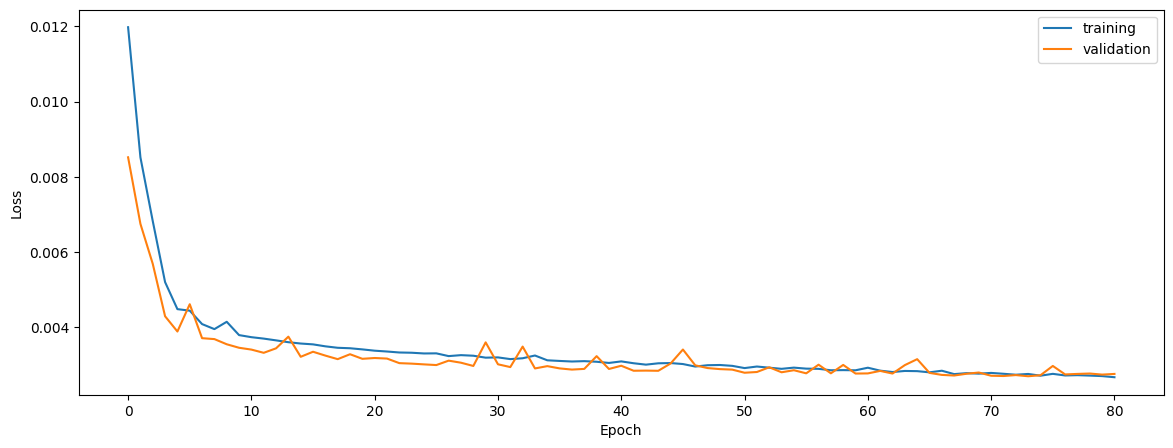

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


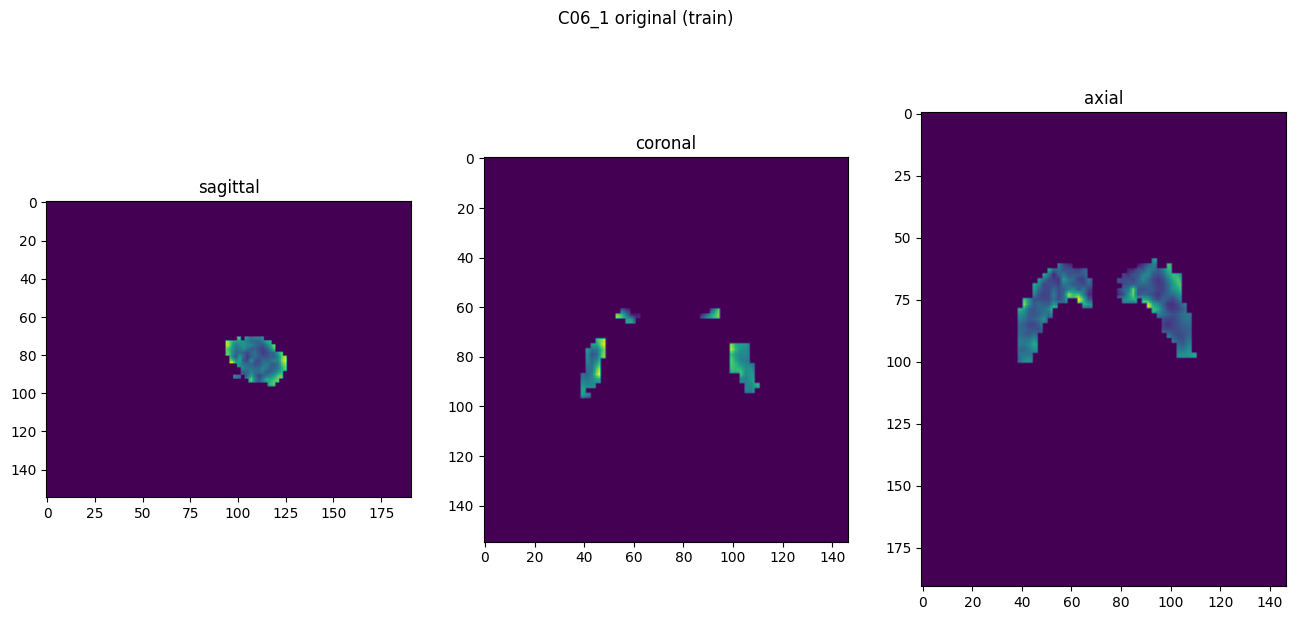

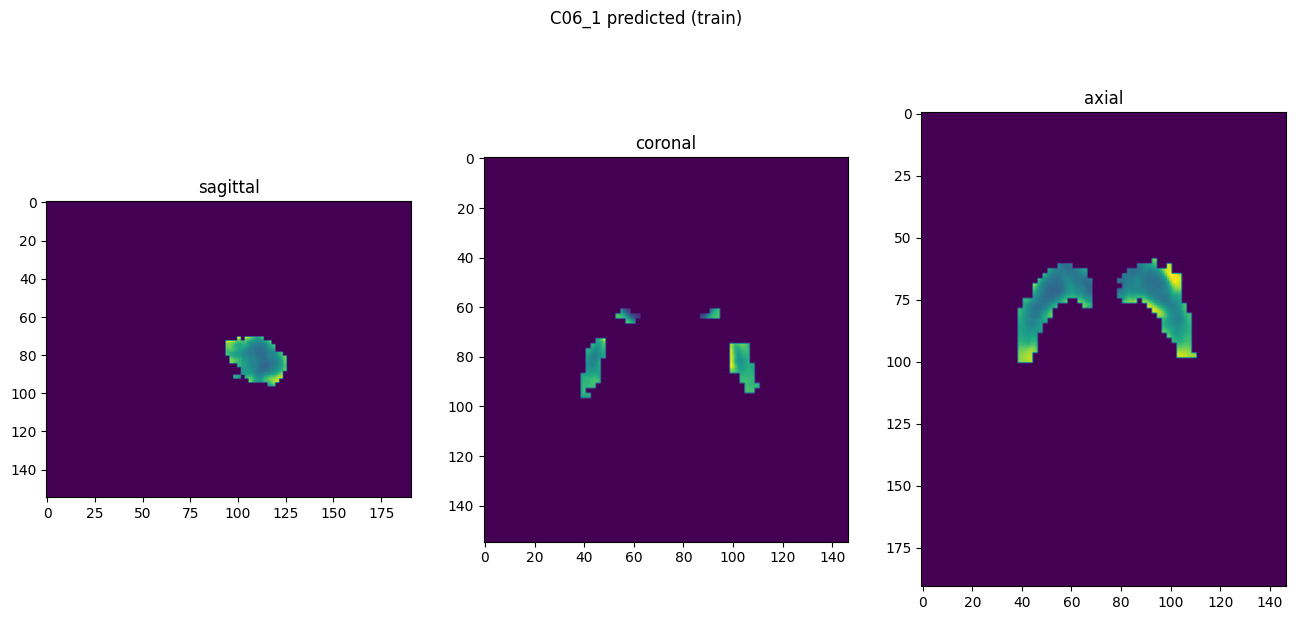

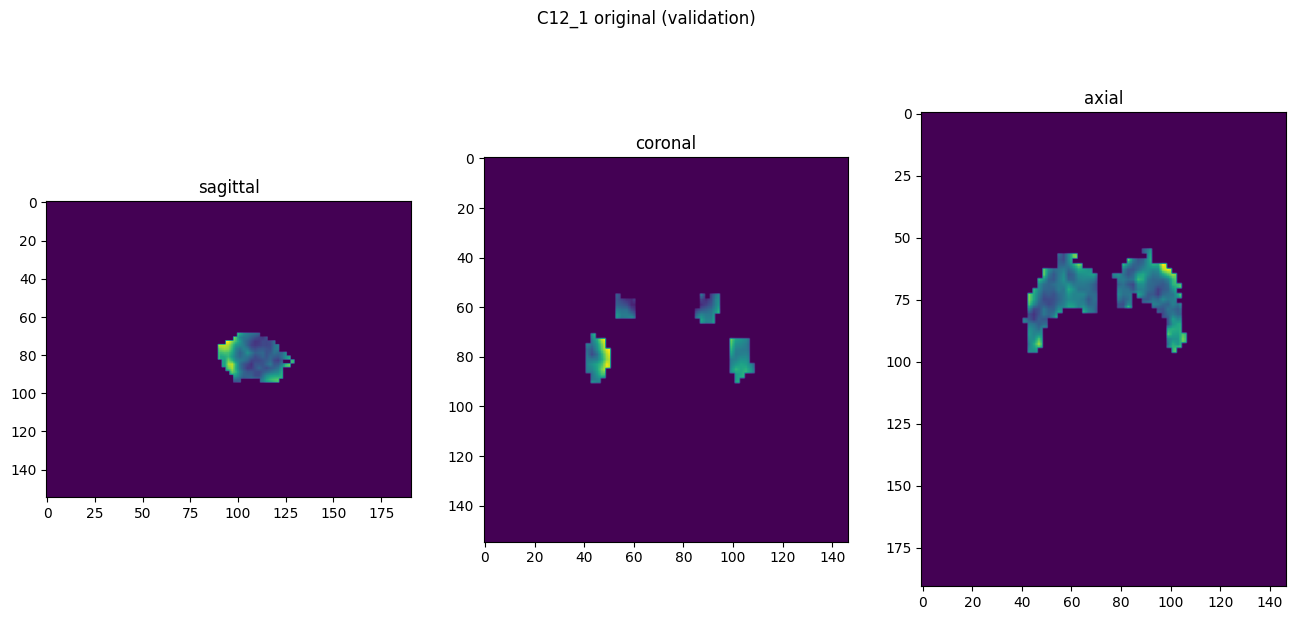

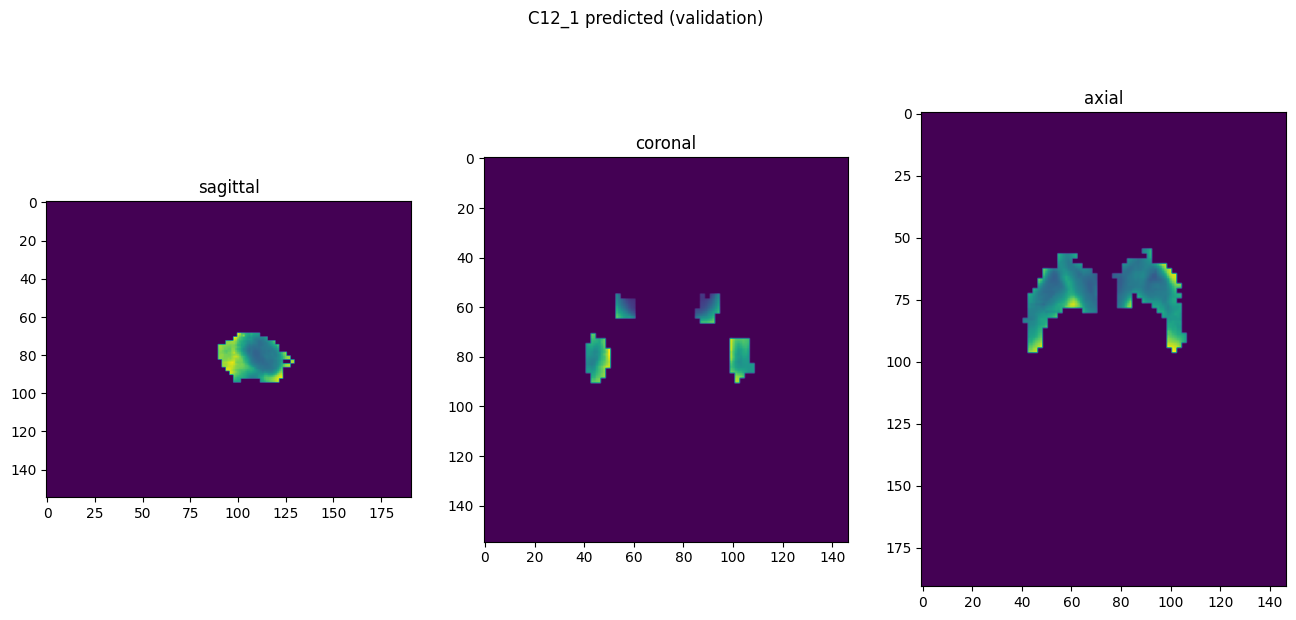

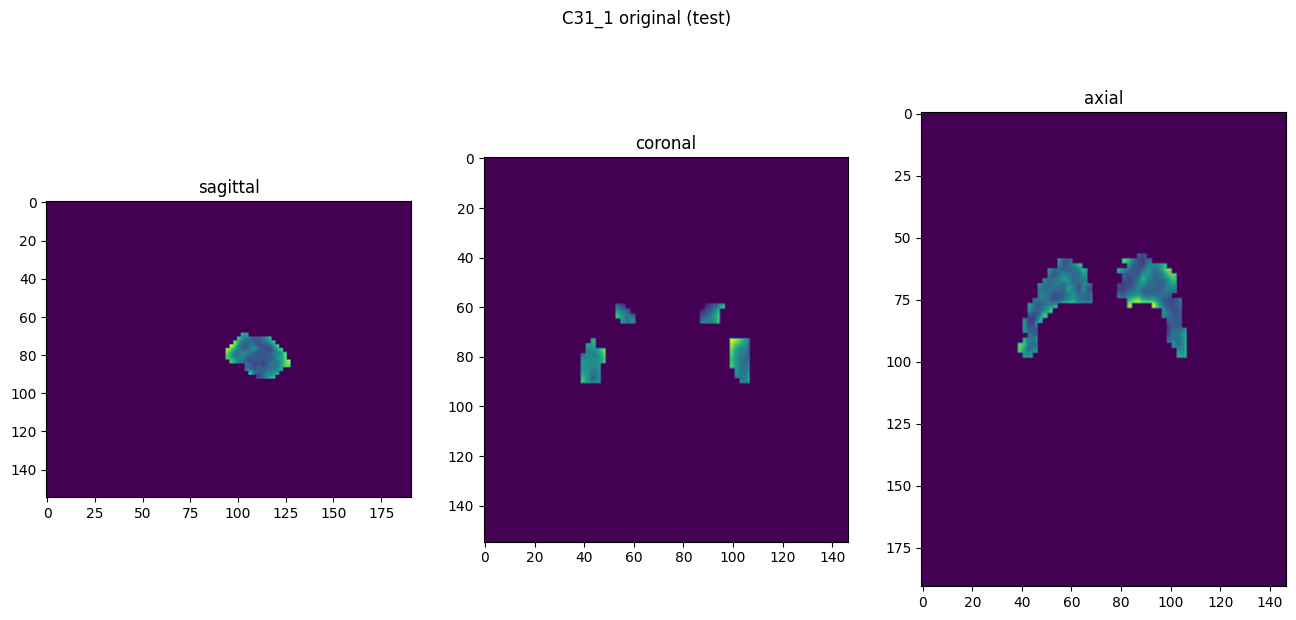

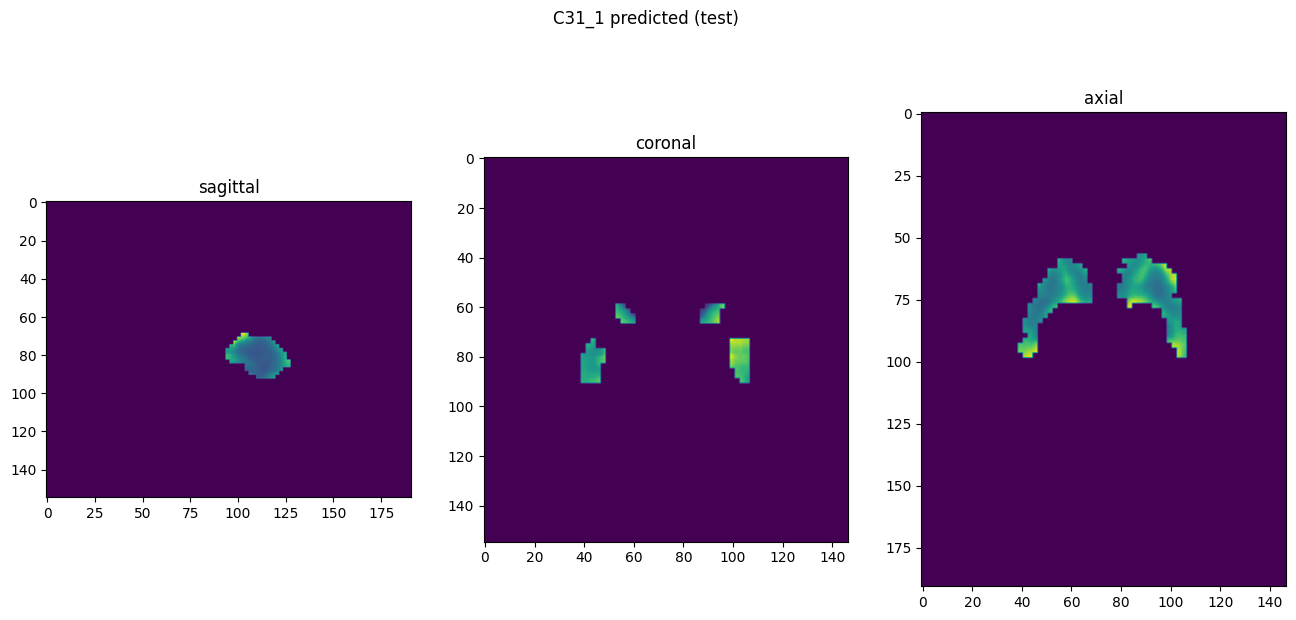

In [10]:
showResults(model, gen, threshold=None, background=False)